In [461]:
# import basic libraries
import pickle
import yt
import numpy as np
import matplotlib.pyplot as plt
from math import log, log10, pi
from astropy import units as u
from yt.utilities.cosmology import Cosmology

# import halo catalogue func
from yt.analysis_modules.halo_analysis.api import *

In [12]:
# import libraries - not sure what they do
# used to ensure halo catalog loads properly
import tempfile
import shutil
import os

# Create temporary directory for storing files
tmpdir = tempfile.mkdtemp()

In [281]:
# load halo dataset
halos_ds = yt.load('./LG4_2048_40pc/rd0110/halo_catalogs/catalog/catalog.0.h5')

# load raw dataset
ds = yt.load('~/../../tigress/cen/LG4_2048_40pc/RD0070/redshift0070')

# Instantiate a catalog using those two paramter files
hc = HaloCatalog(halos_ds=halos_ds, output_dir=os.path.join(tmpdir, 'halo_catalog'))
hc.load()

yt : [INFO     ] 2017-07-28 10:43:25,964 Parameters: current_time              = 6.86908772332e+16
yt : [INFO     ] 2017-07-28 10:43:25,966 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-28 10:43:25,970 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-28 10:43:25,973 Parameters: domain_right_edge         = [  3.33803289e+25   3.33803289e+25   3.33803289e+25]
yt : [INFO     ] 2017-07-28 10:43:25,977 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-28 10:43:25,979 Parameters: current_redshift          = 2.9999999666
yt : [INFO     ] 2017-07-28 10:43:25,981 Parameters: omega_lambda              = 0.712
yt : [INFO     ] 2017-07-28 10:43:25,983 Parameters: omega_matter              = 0.288
yt : [INFO     ] 2017-07-28 10:43:25,985 Parameters: hubble_constant           = 0.6933
yt : [INFO     ] 2017-07-28 10:43:26,042 Parameters: current_time              = 158.01757996843
yt : [INFO     ] 2017-07-28 10:43:26,044 Parame

In [559]:
redshift_filename = './LG4_2048_40pc/rd0070/redshift0070'

# load redshift and Omega values from parameter file
with open(redshift_filename, 'rt') as param_file:
    param_contents = param_file.read()
    
    #redshift
    cindex1 = param_contents.find('CosmologyCurrentRedshift')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    redshift = float(param_contents[cindex_eq+2:cindex2])
    
    # omega_m
    cindex1 = param_contents.find('CosmologyOmegaMatterNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    omega_m = float(param_contents[cindex_eq+2:cindex2])
    
    # hubble const now
    cindex1 = param_contents.find('CosmologyHubbleConstantNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    hubb_now = float(param_contents[cindex_eq+2:cindex2]) *(u.km / u.s / u.Mpc) 
    
    # cosmological constant
    cindex1 = param_contents.find('CosmologyOmegaLambdaNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    cos_const = float(param_contents[cindex_eq+2:cindex2])
    
    # omega baryon as specified by Renyue
    omega_b = 0.048
    
    # box size
    cindex1 = param_contents.find('CosmologyComovingBoxSize')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    box_size = float(param_contents[cindex_eq+2:cindex2]) * u.Mpc
    
    # left edge strings
    cindex1 = param_contents.find('RefineRegionLeftEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    left_edge_string = param_contents[cindex_eq+2:cindex2]
    left_edges = left_edge_string.split()
    
    # right edge strings
    cindex1 = param_contents.find('RefineRegionRightEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    right_edge_string = param_contents[cindex_eq+2:cindex2]
    right_edges = right_edge_string.split()
    
# calculate hubble const for simulation
hubb_z = (100* hubb_now.to('s**-1')) * ((omega_m * (1 + redshift)**3) + (1 - omega_m))**0.5

# calculate crit density and threshold
GRAV_CONST = (6.67408e-11 * u.m**3 /(u.kg * u.s**2)).to('cm^3*g^-1*s^-2')
crit_dens = (3 * hubb_z**2) / (8 * pi * GRAV_CONST)
omegas = (1 - (omega_b / omega_m))
threshold = 200 * omegas * crit_dens

# calculate current time
co = Cosmology(hubb_now.value, omega_m, cos_const)
time_now = co.hubble_time(redshift) * u.s

# min and max bounds for radial profile
# min = 1 kpc proper
# max = 0.5 Mpc comoving
# convert to centimeters value (without astropy units)
rad_min = 1 * u.kpc
rad_max = 0.5 * u.Mpc
rad_max = rad_max / (1 + redshift) # convert to physical

# specify boundaries of zoom-in box
# scaling factor multiplied by info from text file 
# units in cm
scaling =  ((box_size / hubb_now.value) / (1 + redshift)).to('kpc') # size of box
xmin = scaling*float(left_edges[0])
ymin = scaling*float(left_edges[1])
zmin = scaling*float(left_edges[2])
xmax = scaling*float(right_edges[0])
ymax = scaling*float(right_edges[1])
zmax = scaling*float(right_edges[2])

In [560]:
# --load ratio of stellar mass to halo mass
# first list uses first output of TotalMass funct
# second list uses second output

with open('./LG4_2048_40pc/rd0070/ratio_list0070_1.txt', 'rb') as ratiofile1:
    ratiolist1 = pickle.load(ratiofile1)
    
with open('./LG4_2048_40pc/rd0070/ratio_list0070_2.txt', 'rb') as ratiofile2:
    ratiolist2 = pickle.load(ratiofile2)
    
# load master calc list for LG35
with open('./master_calc0030', 'rb') as infile:
    halo_list = pickle.load(infile)

In [284]:
halo_list

[[4,
  4967,
  <Quantity 2730.2707368225533 kpc>,
  <Quantity 2747.750120971941 kpc>,
  <Quantity 2568.162295261254 kpc>,
  <Quantity 17621762811.334885 solMass>,
  <Quantity 13853352350.914053 solMass>,
  <Quantity 10.210570638324075 kpc>,
  <Quantity 22.09330767810782 kpc>,
  370,
  0,
  0,
  0,
  0,
  0],
 [7,
  4966,
  <Quantity 2812.5180462510234 kpc>,
  <Quantity 2848.2499824452275 kpc>,
  <Quantity 2664.8139402915654 kpc>,
  <Quantity 8702273964.894407 solMass>,
  <Quantity 8096654227.7456045 solMass>,
  <Quantity 8.070698947815933 kpc>,
  <Quantity 14.412224034413647 kpc>,
  1213,
  0,
  0,
  0,
  0,
  0],
 [10,
  4965,
  <Quantity 2979.6033034574075 kpc>,
  <Quantity 2406.291726076471 kpc>,
  <Quantity 2929.8603103096616 kpc>,
  <Quantity 8934947593.897242 solMass>,
  <Quantity 7299293197.986081 solMass>,
  <Quantity 8.14199629214509 kpc>,
  <Quantity 12.414740331582161 kpc>,
  2047,
  0,
  0,
  0,
  0,
  0],
 [11,
  4963,
  <Quantity 2910.375991406636 kpc>,
  <Quantity 2976.9

In [561]:
min_mass = 1e10 * u.Msun
mindex = 0

toSkip = (697, 825, 902, 914, 1111, 1211, 556)

count_agezero = 0
count_stelzero = 0
for halo in halo_list:
    mass = halo[5]
    rad = halo[7]
    stellar_mass = halo[11]
    ave_age = halo[12]
    
    if ave_age ==0:
        count_agezero +=1
    if stellar_mass == 0:
        count_stelzero +=1
    

count_agezero, count_stelzero, len(halo_list)

(9666, 9666, 11585)

In [562]:
# create new ratio lists
# < 3e7 Msun, < 3e8 Msun, > 3e8 Msun
# masks used to limit Msun to 3e7-3e8, 3e8-3e9
new_ratiolist11 = []
new_ratiolist12 = []
new_ratiolist13 = []
new_ratiolist21 = []
new_ratiolist22 = []
new_ratiolist23 = []
ave_agelist1 = []
ave_agelist2 = []
ave_agelist3 = []
proxlist1 = []
proxlist2 = []
proxlist3 = []
rad_ratiolist1 = []
rad_ratiolist2 = []
rad_ratiolist3 = []
peaklist1 = []
peaklist2 = []
peaklist3 = []

for halo in halo_list:
    # find parameters of halo
    x = halo[2]
    y = halo[3]
    z = halo[4]
    center = [(x/scaling).value, (y/scaling).value, (z/scaling).value]
    halo_mass = halo[5] # new mass
    radius = halo[7] # new radius
    isSatellite = halo[9]
    gas_mass = halo[10]
    stellar_mass = halo[11]
    ave_age = halo[12]
    prox = halo[13]
    stel_rad = halo[14]
    
    print(halo_mass, stellar_mass2, ave_age)

    # check that not a satellite 
    if isSatellite >= 0:
        print('IsSat')
        continue
    
    # create bools for simplification
    isAgeZero = (ave_age == 0)
    isStelMassZero = (stellar_mass == 0)
    
    # find the ratios
    if not isStelMassZero:
        ratio1 = gas_mass.to('Msun') / halo_mass.to('Msun')
        ratio2 = stellar_mass.to('Msun') / halo_mass.to('Msun')
    else:
        ratio1 = 5e-4
        ratio2 = 5e-7
    
    rad_ratio = (stel_rad / radius).value
    peak_height = (prox * halo_mass) + halo_mass
    
    # set aside the rad ratio of 1
    if isStelMassZero:
        rad_ratio = 5e-4
    
    print(ratio1, ratio2)
    print(isAgeZero, isStelMassZero)
    
    # append differently depending on ave_age == 0
    if isAgeZero and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(11)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(ratio2)
            ave_agelist1.append(1)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
            peaklist1.append(peak_height.value)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(12)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(ratio2)
            ave_agelist2.append(1)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
            peaklist2.append(peak_height.value)
        if halo_mass > 3e9 * u.Msun:
            print(13)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(ratio2)
            ave_agelist3.append(1)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
            peaklist3.append(peak_height.value)
    if isAgeZero and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(21)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(5e-7)
            ave_agelist1.append(1)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
            peaklist1.append(peak_height.value)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(22)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(5e-7)
            ave_agelist2.append(1)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
            peaklist2.append(peak_height.value)
        if halo_mass > 3e9 * u.Msun:
            print(23)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(5e-7)
            ave_agelist3.append(1)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
            peaklist3.append(peak_height.value)
    if (not isAgeZero) and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(31)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(5e-7)
            ave_agelist1.append(ave_age.to('Myr').value)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
            peaklist1.append(peak_height.value)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(32)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(5e-7)
            ave_agelist2.append(ave_age.to('Myr').value)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
            peaklist2.append(peak_height.value)
        if halo_mass > 3e9 * u.Msun:
            print(33)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(5e-7)
            ave_agelist3.append(ave_age.to('Myr').value)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
            peaklist3.append(peak_height.value)
    if (not isAgeZero) and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(4)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(ratio2.value)
            ave_agelist1.append(ave_age.to('Myr').value)
            proxlist1.append(prox)
            rad_ratiolist1.append(rad_ratio)
            peaklist1.append(peak_height.value)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(5)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(ratio2.value)
            ave_agelist2.append(ave_age.to('Myr').value)
            proxlist2.append(prox)
            rad_ratiolist2.append(rad_ratio)
            peaklist2.append(peak_height.value)
        if halo_mass > 3e9 * u.Msun:
            print(6)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(ratio2.value)
            ave_agelist3.append(ave_age.to('Myr').value)
            proxlist3.append(prox)
            rad_ratiolist3.append(rad_ratio)
            peaklist3.append(peak_height.value)

# convert peaklist to arrays
new_peaklist1 = np.array(peaklist1)
new_peaklist2 = np.array(peaklist2)
new_peaklist3 = np.array(peaklist3)

9060402645.837389 solMass 0 5095953707694528.0 s
0.11999741060775462 0.019842642654274968
False False
6
7849008048.218473 solMass 0 5753502563457781.0 s
0.1444329202410632 0.026847642765060176
False False
6
7399207108.754084 solMass 0 3617965343074710.5 s
0.13905587098187286 0.017773430337778156
False False
6
6012712815.028287 solMass 0 1862215628557441.0 s
0.16687955814564406 0.012952754806321945
False False
6
5308698775.584763 solMass 0 5498501305586913.0 s
0.170178699023267 0.04059452085953231
False False
6
5091044155.85847 solMass 0 4980803458496731.0 s
0.15086149902350682 0.023513364910740797
False False
6
4602954228.913103 solMass 0 4234330093470323.5 s
0.162255023348166 0.022605408040481372
False False
6
3811687379.60136 solMass 0 5977821045678439.0 s
0.16680356136719318 0.015933930227074258
False False
6
4450990193.589116 solMass 0 3044701690635589.5 s
0.19092361565599708 0.012946320932101097
False False
6
3948361569.5120573 solMass 0 4573367851751644.0 s
0.22155755316841985 0.

1008847385.9579287 solMass 0 1942294224720906.0 s
0.20160417072495845 0.0001340742322420422
False False
5
851267156.4830651 solMass 0 2958650921123309.5 s
0.2352776542241362 0.012213293223857174
False False
5
814287767.9131743 solMass 0 1115269949919524.4 s
0.24729640049806872 0.0023815311435285186
False False
5
820426008.8691033 solMass 0 1921643173370197.5 s
0.2044987514814905 0.000565269935043072
False False
5
869279061.5525221 solMass 0 2641603393782798.0 s
0.1864265532642677 0.0008242306391395544
False False
5
708469021.6372963 solMass 0 4603751679324788.0 s
0.2576067931834009 0.0025062042935206025
False False
5
794843089.0893139 solMass 0 2895699079452007.5 s
0.21078928941943278 0.006845905045563524
False False
5
815398982.6278459 solMass 0 2702637418269965.5 s
0.23216435674985078 2.1833580303664753e-05
False False
5
693759135.4745066 solMass 0 5396015592347174.0 s
0.24239989283547417 0.01694220754729357
False False
5
816794668.7920184 solMass 0 5072735771042442.0 s
0.21891206289

0.24168608375356596 0.0089360631810468
False False
5
477872341.48642 solMass 0 838243491107125.0 s
0.2739688032143952 0.0006183792938763485
False False
5
509706457.7961231 solMass 0 3211434158694932.0 s
0.21685168030504318 0.003138821803802975
False False
5
484825300.77280396 solMass 0 2987363528498750.5 s
0.2296879308103308 0.0006916826189047919
False False
5
454069210.4914255 solMass 0 5494484366930306.0 s
0.23934252005867016 0.001402161674044175
False False
5
435495876.28376937 solMass 0 612631956612228.6 s
0.2014003320098419 0.0002278230733399707
False False
5
491271912.51894987 solMass 0 0.0 s
0.0005 5e-07
True True
22
448487612.1389599 solMass 0 489423682643848.8 s
0.22879619644093901 0.000568442461752685
False False
5
494466025.14442706 solMass 0 1.0344719686315994e+16 s
0.09616538984552671 0.002171072271238345
False False
5
486776828.5956334 solMass 0 2261551514407612.5 s
0.21003363992795918 0.0022804500164363543
False False
5
381913975.9929425 solMass 0 5734108773389636.0 s
0.

305554427.1951002 solMass 0 2428391530638652.0 s
0.1707751220618608 0.0016880510004933617
False False
5
412038394.4530271 solMass 0 5916492189562378.0 s
0.12784234256395144 0.0007937303951194374
False False
5
247726417.38410637 solMass 0 1.0982707875384718e+16 s
0.21958233907469404 2.0799021320386163e-05
False False
4
329063741.8968679 solMass 0 5702621221490297.0 s
0.36395974171580847 6.263184156325103e-05
False False
5
423623846.8359575 solMass 0 1563348966828098.0 s
0.15779051698080301 6.081417600965475e-05
False False
5
265667436.67206132 solMass 0 3766390157084438.5 s
0.2970315213038665 0.011133306984828164
False False
4
334993253.80644274 solMass 0 69157230800376.48 s
0.11576950574063538 0.00036686922487653376
False False
5
281013408.57260966 solMass 0 1827098799241363.0 s
0.2054832690282332 0.002140777209340577
False False
4
209229983.35405025 solMass 0 2656423943143353.0 s
0.4887466655698873 0.012372852797441526
False False
4
265036045.62995657 solMass 0 1.1182311855838476e+16 

0.4094417056896384 0.0011193926173274677
False False
4
291200613.4899089 solMass 0 0.0 s
0.0005 5e-07
True True
21
298893923.49847573 solMass 0 0.0 s
0.0005 5e-07
True True
21
109795212.16346186 solMass 0 0.0 s
0.0005 5e-07
True True
21
342009962.1502347 solMass 0 2424395433447781.0 s
0.15213921995600554 0.0002787072036708499
False False
5
183863285.9029429 solMass 0 0.0 s
0.0005 5e-07
True True
21
170452992.51228404 solMass 0 6812938249018277.0 s
0.40819855647250985 4.534212301643047e-05
False False
4
209562728.67037618 solMass 0 3185805916646309.0 s
0.35022854090342936 0.007972053607211288
False False
4
245057060.8428819 solMass 0 0.0 s
0.0005 5e-07
True True
21
198608044.74224946 solMass 0 1382864556958167.0 s
0.19631502375245877 0.001709722669673078
False False
4
195255614.54768893 solMass 0 1726110883492504.2 s
0.3058059335918525 0.0016454634657384697
False False
4
229227841.94944695 solMass 0 4269996939114766.0 s
0.28353140442390556 0.0006974081578093068
False False
4
212298881.9

103559220.14768086 solMass 0 0.0 s
0.0005 5e-07
True True
21
163845268.73672867 solMass 0 0.0 s
0.0005 5e-07
True True
21
235720481.66385067 solMass 0 0.0 s
0.0005 5e-07
True True
21
136286435.0285118 solMass 0 6663949546565785.0 s
0.3730558788581911 0.017043314032708215
False False
4
97841103.3273395 solMass 0 2882606858861938.5 s
0.34763365213100766 0.0007372621123465673
False False
4
112091238.14285271 solMass 0 0.0 s
0.0005 5e-07
True True
21
130438957.79572755 solMass 0 0.0 s
0.0005 5e-07
True True
21
121066177.72938813 solMass 0 0.0 s
0.0005 5e-07
True True
21
126324468.8179161 solMass 0 0.0 s
0.0005 5e-07
True True
21
188752542.7403292 solMass 0 0.0 s
0.0005 5e-07
True True
21
106940408.76944447 solMass 0 0.0 s
0.0005 5e-07
True True
21
132732272.3247147 solMass 0 6249806278108116.0 s
0.39874241620357564 0.0026974273124488915
False False
4
83469904.02957726 solMass 0 0.0 s
0.0005 5e-07
True True
21
135406795.92828903 solMass 0 0.0 s
0.0005 5e-07
True True
21
126969212.50235546 s

92196376.7493491 solMass 0 1412928625576790.5 s
0.5098121432337495 0.010791356585370556
False False
4
85057111.02816676 solMass 0 0.0 s
0.0005 5e-07
True True
21
128753896.8035524 solMass 0 0.0 s
0.0005 5e-07
True True
21
154183526.64524806 solMass 0 0.0 s
0.0005 5e-07
True True
21
145313484.91836268 solMass 0 3401360031570819.0 s
0.1716834935497932 0.00438464179900166
False False
4
142648510.11135498 solMass 0 5938420194518408.0 s
0.17761324348609858 1.8060009994677286e-05
False False
4
136305836.3964484 solMass 0 0.0 s
0.0005 5e-07
True True
21
84406854.57835937 solMass 0 0.0 s
0.0005 5e-07
True True
21
175699314.10910273 solMass 0 0.0 s
0.0005 5e-07
True True
21
100364834.6000675 solMass 0 0.0 s
0.0005 5e-07
True True
21
129789199.2078232 solMass 0 0.0 s
0.0005 5e-07
True True
21
104362352.19778502 solMass 0 0.0 s
0.0005 5e-07
True True
21
114887615.05607662 solMass 0 0.0 s
0.0005 5e-07
True True
21
124442240.63495135 solMass 0 0.0 s
0.0005 5e-07
True True
21
81188307.86807047 solMa

True True
21
102383796.59689617 solMass 0 0.0 s
0.0005 5e-07
True True
21
74687031.81326604 solMass 0 0.0 s
0.0005 5e-07
True True
21
126870380.71625786 solMass 0 0.0 s
0.0005 5e-07
True True
21
95084403.73714466 solMass 0 0.0 s
0.0005 5e-07
True True
21
100348488.68444258 solMass 0 0.0 s
0.0005 5e-07
True True
21
153159938.72930837 solMass 0 0.0 s
0.0005 5e-07
True True
21
94270093.6159575 solMass 0 0.0 s
0.0005 5e-07
True True
21
61972490.59114279 solMass 0 0.0 s
0.0005 5e-07
True True
21
77915394.38762338 solMass 0 3402558531355206.5 s
0.34963086114784453 0.00013225799797766908
False False
4
108805457.09699236 solMass 0 0.0 s
0.0005 5e-07
True True
21
77270983.58242247 solMass 0 0.0 s
0.0005 5e-07
True True
21
87383392.8533918 solMass 0 0.0 s
0.0005 5e-07
True True
21
96450807.11882877 solMass 0 0.0 s
0.0005 5e-07
True True
21
104008327.40513176 solMass 0 0.0 s
0.0005 5e-07
True True
21
172228114.55420256 solMass 0 0.0 s
0.0005 5e-07
True True
21
105306247.707711 solMass 0 0.0 s
0.0

/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:968: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)


0.0005 5e-07
True True
94287578.7111244 solMass 0 0.0 s
0.0005 5e-07
True True
21
92892684.40107062 solMass 0 0.0 s
0.0005 5e-07
True True
21
66821371.754714005 solMass 0 0.0 s
0.0005 5e-07
True True
21
116753175.53753176 solMass 0 0.0 s
0.0005 5e-07
True True
21
111571267.03196742 solMass 0 0.0 s
0.0005 5e-07
True True
21
109408942.7951675 solMass 0 0.0 s
0.0005 5e-07
True True
21
80869973.58725752 solMass 0 0.0 s
0.0005 5e-07
True True
21
181854432.80788362 solMass 0 0.0 s
0.0005 5e-07
True True
21
63119022.6536687 solMass 0 0.0 s
0.0005 5e-07
True True
21
81859544.40239497 solMass 0 0.0 s
0.0005 5e-07
True True
21
69913682.32626304 solMass 0 0.0 s
0.0005 5e-07
True True
21
90619167.69387227 solMass 0 0.0 s
0.0005 5e-07
True True
21
56202803.59723288 solMass 0 0.0 s
0.0005 5e-07
True True
21
72131674.20246205 solMass 0 6930914737637934.0 s
0.4064732078951365 3.5715703909849936e-05
False False
4
125950404.78901456 solMass 0 0.0 s
0.0005 5e-07
True True
21
78295710.43448867 solMass 0 0

0.0005 5e-07
True True
21
64495104.53012868 solMass 0 1909822914597186.2 s
0.5497095628960627 0.00023966782010253966
False False
4
70378233.228888 solMass 0 0.0 s
0.0005 5e-07
True True
21
45598550.1130592 solMass 0 9248831650609214.0 s
0.642035034412274 0.0001129962909821392
False False
4
56625735.19524786 solMass 0 0.0 s
0.0005 5e-07
True True
21
69570947.09028794 solMass 0 0.0 s
0.0005 5e-07
True True
21
53314863.124258496 solMass 0 3960086351768047.5 s
0.4414579683482397 0.0002899266771818492
False False
4
26869571.988429 solMass 0 0.0 s
0.0005 5e-07
True True
111835188.46429224 solMass 0 0.0 s
0.0005 5e-07
True True
21
45691809.56869883 solMass 0 0.0 s
0.0005 5e-07
True True
21
72266976.82140328 solMass 0 3932393727355172.5 s
0.13486116237005205 0.0011268952442725281
False False
4
57061115.25441642 solMass 0 2975942133511163.0 s
0.3717305752054316 0.0006899573706579692
False False
4
83920332.20652092 solMass 0 0.0 s
0.0005 5e-07
True True
21
45301227.44071015 solMass 0 0.0 s
0.000

0.0005 5e-07
True True
21
95225790.56573913 solMass 0 0.0 s
0.0005 5e-07
True True
21
54003666.879726514 solMass 0 6924928171249692.0 s
0.4832184684759493 4.7704788715079605e-05
False False
4
69711838.82247813 solMass 0 0.0 s
0.0005 5e-07
True True
21
43345984.15269233 solMass 0 0.0 s
0.0005 5e-07
True True
21
73569859.45949279 solMass 0 0.0 s
0.0005 5e-07
True True
21
62191394.80859713 solMass 0 0.0 s
0.0005 5e-07
True True
21
53558776.013028614 solMass 0 0.0 s
0.0005 5e-07
True True
21
75119015.83399764 solMass 0 0.0 s
0.0005 5e-07
True True
21
70194821.34312303 solMass 0 0.0 s
0.0005 5e-07
True True
21
54261975.37730489 solMass 0 0.0 s
0.0005 5e-07
True True
21
49209256.170968 solMass 0 0.0 s
0.0005 5e-07
True True
21
67623814.08707257 solMass 0 0.0 s
0.0005 5e-07
True True
21
64321873.930038616 solMass 0 0.0 s
0.0005 5e-07
True True
21
60737343.36960767 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
49334176.89821468 solMass 0 0.0 s
0.0005 5e-07
Tr

0.0005 5e-07
True True
21
48857132.22004417 solMass 0 0.0 s
0.0005 5e-07
True True
21
39371079.67872094 solMass 0 0.0 s
0.0005 5e-07
True True
21
35347349.774721086 solMass 0 0.0 s
0.0005 5e-07
True True
21
43916990.91786901 solMass 0 0.0 s
0.0005 5e-07
True True
21
49712771.17311376 solMass 0 0.0 s
0.0005 5e-07
True True
21
60946249.77802755 solMass 0 0.0 s
0.0005 5e-07
True True
21
62356604.211751945 solMass 0 0.0 s
0.0005 5e-07
True True
21
53735997.39599396 solMass 0 0.0 s
0.0005 5e-07
True True
21
28956659.647750832 solMass 0 0.0 s
0.0005 5e-07
True True
43657112.9820348 solMass 0 0.0 s
0.0005 5e-07
True True
21
52105305.25829161 solMass 0 0.0 s
0.0005 5e-07
True True
21
61220156.1797383 solMass 0 0.0 s
0.0005 5e-07
True True
21
51670774.90111731 solMass 0 0.0 s
0.0005 5e-07
True True
21
36776901.173635684 solMass 0 0.0 s
0.0005 5e-07
True True
21
28083598.76051112 solMass 0 0.0 s
0.0005 5e-07
True True
43744214.383335195 solMass 0 4900828256838428.0 s
0.11928813288918932 0.005300

51889927.58691861 solMass 0 0.0 s
0.0005 5e-07
True True
21
41062333.25110638 solMass 0 0.0 s
0.0005 5e-07
True True
21
61849979.61015755 solMass 0 0.0 s
0.0005 5e-07
True True
21
32791343.53989613 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
37183742.33075294 solMass 0 0.0 s
0.0005 5e-07
True True
21
41007846.496668674 solMass 0 0.0 s
0.0005 5e-07
True True
21
44903103.94206091 solMass 0 0.0 s
0.0005 5e-07
True True
21
72876452.6932219 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
39742858.31005669 solMass 0 0.0 s
0.0005 5e-07
True True
21
21092038.04502938 solMass 0 4761711533785000.0 s
0.056251893309175106 0.008672115013799032
False False
44339789.56454785 solMass 0 0.0 s
0.0005 5e-07
True True
21
28778873.62657156 solMass 0 0.0 s
0.0005 5e-07
True True
20709874.7895171 solMass 0 0.0 s
0.0005 5e-07
True True
59322603.841783546 solMass 0 0.0 s
0.0005 5e-07
True True
21
38428972.27436917 solMass 0 0.0 s
0.0005 5e-0

39474414.166215226 solMass 0 0.0 s
0.0005 5e-07
True True
21
48774131.249922656 solMass 0 0.0 s
0.0005 5e-07
True True
21
33991751.10354692 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
26035186.779209986 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29667667.728497714 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22945104.690353785 solMass 0 0.0 s
0.0005 5e-07
True True
37214675.152729414 solMass 0 0.0 s
0.0005 5e-07
True True
21
25930551.57818948 solMass 0 0.0 s
0.0005 5e-07
True True
28864615.95603196 solMass 0 0.0 s
0.0005 5e-07
True True
30945447.766444158 solMass 0 0.0 s
0.0005 5e-07
True True
21
31194723.139787935 solMass 0 0.0 s
0.0005 5e-07
True True
21
44451768.240117565 solMass 0 0.0 s
0.0005 5e-07
True True
21
47000664.347255245 solMass 0 0.0 s
0.0005 5e-07
True True
21
26511919.783527736 solMass 0 0.0 s
0.0005 5e-07
True True
35130212.668079585 solMass 0 5705641527599281.0 s


0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
56218794.04185274 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
35336215.3300725 solMass 0 0.0 s
0.0005 5e-07
True True
21
55328764.60716257 solMass 0 0.0 s
0.0005 5e-07
True True
21
47552204.16993268 solMass 0 0.0 s
0.0005 5e-07
True True
21
28515380.17328405 solMass 0 0.0 s
0.0005 5e-07
True True
36576703.302720286 solMass 0 0.0 s
0.0005 5e-07
True True
21
56142818.17814444 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31054554.607911043 solMass 0 0.0 s
0.0005 5e-07
True True
21
45920730.41431161 solMass 0 0.0 s
0.0005 5e-07
True True
21
43562094.95845016 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29877208.548916377 solMass 0 0.0 s
0.0005 5e-07
Tru

True True
70046485.4230966 solMass 0 0.0 s
0.0005 5e-07
True True
21
46261409.35328145 solMass 0 0.0 s
0.0005 5e-07
True True
21
27037125.839391153 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25706804.548602484 solMass 0 0.0 s
0.0005 5e-07
True True
28418696.460663423 solMass 0 0.0 s
0.0005 5e-07
True True
24656298.33046816 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31391248.667897135 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26614545.255827956 solMass 0 0.0 s
0.0005 5e-07
True True
37411937.472526215 solMass 0 0.0 s
0.0005 5e-07
True True
21
33004308.15725048 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
38806016.69739756 solMass 0 0.0 s
0.0005 5e-07
Tr

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25651738.761022635 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
55285914.0538433 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
35539867.279170714 solMass 0 0.0 s
0.0005 5e-07
True True
21
26226963.951179575 solMass 0 0.0 s
0.0005 5e-07
True True
29173957.971718535 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34286913.24357813 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
31618785.921530046 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25530211.774839696 solMass 0 0.0 s
0.0005 5e-07
True True
30889683.805704318 s

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22717212.848500438 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29891643.03245692 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27860634.283725034 solMass 0 0.0 s
0.0005 5e-07
True True
27558581.79595114 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
40254343.41642722 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26079868.872135863 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 s

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30141378.03345659 solMass 0 0.0 s
0.0005 5e-07
True True
21
32510954.31710474 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22508982.52119824 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.00

0.2704842725348914 0.01032372100947616
False False
5
870499805.1474898 solMass 0 1746193879548926.2 s
0.2277888377036202 0.009142471428657564
False False
5
891273184.7606157 solMass 0 3155021367175790.5 s
0.3096034173589169 0.014226549818752899
False False
5
1012231745.4063956 solMass 0 4145091095504392.0 s
0.2045808630935423 0.000278834926206253
False False
5
971804398.1882341 solMass 0 3641557693268435.0 s
0.1981826019740304 0.0011113308058516742
False False
5
813526291.147164 solMass 0 4818367116547051.0 s
0.21735090784184408 0.008313051719732362
False False
5
763217297.3102597 solMass 0 2521181913075481.5 s
0.21658365466158336 0.0048459275338725415
False False
5
1064589953.4306662 solMass 0 655722154475231.1 s
0.18241923563413526 0.00018160755221455357
False False
5
813144019.9362814 solMass 0 2003666032572368.2 s
0.2062997835249974 0.004687818518894032
False False
5
776182171.4301603 solMass 0 3319302920042353.5 s
0.30553123776743846 0.030347799956004794
False False
5
764362849.00

0.22356558273599658 0.007805741202506684
False False
5
468039594.3541195 solMass 0 3562060313188225.5 s
0.26151559801810825 0.0035836809188137925
False False
5
421797530.4655443 solMass 0 3166088607005598.5 s
0.3424680650274911 0.0008920240713745681
False False
5
341051165.8642908 solMass 0 2925231448350827.5 s
0.2670999145934587 0.0005528330834409113
False False
5
373768775.2818044 solMass 0 9991925953780040.0 s
0.2525092328124494 0.00046869586453530157
False False
5
471310467.8639603 solMass 0 2405299492332770.0 s
0.2724843367484216 0.00038299160205379533
False False
5
456086282.1731081 solMass 0 5890124931930945.0 s
0.22146537287610568 0.004444040349455307
False False
5
458016664.0248801 solMass 0 1.2009431481404024e+16 s
0.2576263331177654 0.0005568511767270656
False False
5
426642407.0796988 solMass 0 2464463526529662.5 s
0.19422816106818055 0.0007397987068415733
False False
5
451289439.3903295 solMass 0 0.0 s
0.0005 5e-07
True True
22
531512835.3436557 solMass 0 0.0 s
0.0005 5e-0

442820489.94213367 solMass 0 0.0 s
0.0005 5e-07
True True
22
225331926.056871 solMass 0 5788759374703118.0 s
0.3274224210923246 0.0014014847322968962
False False
4
312696056.01186204 solMass 0 0.0 s
0.0005 5e-07
True True
22
255827381.43335858 solMass 0 0.0 s
0.0005 5e-07
True True
21
383163624.975537 solMass 0 2170245929463668.5 s
0.20164189057978577 4.8031711906405084e-05
False False
5
265176300.95397082 solMass 0 3893779459147678.5 s
0.4275541087762885 0.01722883019084627
False False
4
313104990.2773289 solMass 0 0.0 s
0.0005 5e-07
True True
22
284232040.08765346 solMass 0 3660516037304998.0 s
0.2622788449880564 5.4383035442642254e-05
False False
4
255611062.85240397 solMass 0 0.0 s
0.0005 5e-07
True True
21
240414791.21333796 solMass 0 8021860690760757.0 s
0.2658180836625999 0.0008241565524066568
False False
4
258694914.02294636 solMass 0 4152198398295120.0 s
0.2140095742440384 0.0003310788780747809
False False
4
240522769.71467742 solMass 0 0.0 s
0.0005 5e-07
True True
21
17053955

173635456.54042906 solMass 0 0.0 s
0.0005 5e-07
True True
21
173485656.7951353 solMass 0 1806523842812762.8 s
0.5992338981260553 0.003191282553165341
False False
4
208907477.12595424 solMass 0 0.0 s
0.0005 5e-07
True True
21
218476619.68186888 solMass 0 3414808176952100.0 s
0.27047490083905545 0.0005536539549472757
False False
4
267446752.3208251 solMass 0 0.0 s
0.0005 5e-07
True True
21
153428652.36128378 solMass 0 8429634970909813.0 s
0.4634870545488057 0.0015951530597758678
False False
4
163751818.3393125 solMass 0 0.0 s
0.0005 5e-07
True True
21
127383165.82134749 solMass 0 1.2919645580469734e+16 s
0.24806027263706265 0.0008763073649376343
False False
4
190297288.37419444 solMass 0 1659194622291974.8 s
0.28697730358624074 0.00012954546363267547
False False
4
209059020.16986886 solMass 0 954943132535732.4 s
0.4231319706035375 0.00011689056545597316
False False
4
187779322.45249644 solMass 0 2388603120315931.0 s
0.5403137108130683 0.002374576803542593
False False
4
182843081.58114627

184995826.70731014 solMass 0 0.0 s
0.0005 5e-07
True True
21
132141323.45358726 solMass 0 4914707696421057.0 s
0.31927644012025014 0.0005263932824006726
False False
4
140036325.42898363 solMass 0 0.0 s
0.0005 5e-07
True True
21
154437950.51855344 solMass 0 0.0 s
0.0005 5e-07
True True
21
264104303.4759837 solMass 0 0.0 s
0.0005 5e-07
True True
21
110631901.67615809 solMass 0 0.0 s
0.0005 5e-07
True True
21
178566995.76476622 solMass 0 0.0 s
0.0005 5e-07
True True
21
193297435.03497845 solMass 0 0.0 s
0.0005 5e-07
True True
21
216908137.10039514 solMass 0 1.1748123354368554e+16 s
0.1045000503711968 0.0007126243079975819
False False
4
130507943.93342242 solMass 0 2447634158681282.5 s
0.6252823321982147 0.0033998531472669287
False False
4
150214672.11395255 solMass 0 0.0 s
0.0005 5e-07
True True
21
146401843.2838932 solMass 0 2681392120293476.0 s
0.27762814524536994 0.0016036588255341172
False False
4
182692789.93569595 solMass 0 0.0 s
0.0005 5e-07
True True
21
82283770.83749703 solMass 0

132609176.53562671 solMass 0 0.0 s
0.0005 5e-07
True True
21
119101193.67778617 solMass 0 0.0 s
0.0005 5e-07
True True
21
62855942.01943902 solMass 0 8774131157577140.0 s
0.5165264144261882 0.00028690421382125073
False False
4
108816754.05502224 solMass 0 0.0 s
0.0005 5e-07
True True
21
72504237.72700578 solMass 0 0.0 s
0.0005 5e-07
True True
21
84171938.88754077 solMass 0 0.0 s
0.0005 5e-07
True True
21
81074384.94879071 solMass 0 0.0 s
0.0005 5e-07
True True
21
90341488.64985058 solMass 0 0.0 s
0.0005 5e-07
True True
21
94759103.51159592 solMass 0 0.0 s
0.0005 5e-07
True True
21
92549434.55608527 solMass 0 0.0 s
0.0005 5e-07
True True
21
145018102.71983716 solMass 0 0.0 s
0.0005 5e-07
True True
21
67577404.24539977 solMass 0 0.0 s
0.0005 5e-07
True True
21
48637863.50675522 solMass 0 0.0 s
0.0005 5e-07
True True
21
57432567.88273672 solMass 0 0
IsSat
101798557.70721388 solMass 0 0.0 s
0.0005 5e-07
True True
21
77373553.97085765 solMass 0 0.0 s
0.0005 5e-07
True True
21
91873495.79458

133849172.37963295 solMass 0 0.0 s
0.0005 5e-07
True True
21
61362116.81736878 solMass 0 0.0 s
0.0005 5e-07
True True
21
69053202.10829006 solMass 0 0.0 s
0.0005 5e-07
True True
21
64532297.38347063 solMass 0 0.0 s
0.0005 5e-07
True True
21
76276149.41662899 solMass 0 0.0 s
0.0005 5e-07
True True
21
68536684.1952688 solMass 0 0.0 s
0.0005 5e-07
True True
21
66545286.168330744 solMass 0 0.0 s
0.0005 5e-07
True True
21
53133370.160571285 solMass 0 0.0 s
0.0005 5e-07
True True
21
87059259.4711097 solMass 0 0.0 s
0.0005 5e-07
True True
21
71961506.83401199 solMass 0 0.0 s
0.0005 5e-07
True True
21
51364741.85518774 solMass 0 0.0 s
0.0005 5e-07
True True
21
52689419.919378385 solMass 0 0.0 s
0.0005 5e-07
True True
21
109046284.63404356 solMass 0 0.0 s
0.0005 5e-07
True True
21
38373423.434824795 solMass 0 0.0 s
0.0005 5e-07
True True
21
152059518.32535198 solMass 0 0.0 s
0.0005 5e-07
True True
21
117124022.72380166 solMass 0 0.0 s
0.0005 5e-07
True True
21
75817340.28735527 solMass 0 0.0 s


74673372.39081612 solMass 0 0.0 s
0.0005 5e-07
True True
21
32597501.026638918 solMass 0 0.0 s
0.0005 5e-07
True True
21
48914160.08621641 solMass 0 0.0 s
0.0005 5e-07
True True
21
57030939.79297785 solMass 0 0.0 s
0.0005 5e-07
True True
21
122917553.79175937 solMass 0 0.0 s
0.0005 5e-07
True True
21
59240807.364247404 solMass 0 0
IsSat
65827019.59786265 solMass 0 0.0 s
0.0005 5e-07
True True
21
25480848.89583413 solMass 0 0.0 s
0.0005 5e-07
True True
59224991.96526544 solMass 0 0.0 s
0.0005 5e-07
True True
21
60932971.24652266 solMass 0 0.0 s
0.0005 5e-07
True True
21
58168260.649716064 solMass 0 0.0 s
0.0005 5e-07
True True
21
36622475.58315385 solMass 0 0.0 s
0.0005 5e-07
True True
21
38196393.39392763 solMass 0 0.0 s
0.0005 5e-07
True True
21
69084487.6204611 solMass 0 0.0 s
0.0005 5e-07
True True
21
49454327.27845647 solMass 0 0.0 s
0.0005 5e-07
True True
21
82282074.5515546 solMass 0 0.0 s
0.0005 5e-07
True True
21
64251247.473094776 solMass 0 0.0 s
0.0005 5e-07
True True
21
6026

55206811.769605406 solMass 0 0.0 s
0.0005 5e-07
True True
21
34157816.82771361 solMass 0 0.0 s
0.0005 5e-07
True True
21
50487668.257580504 solMass 0 0.0 s
0.0005 5e-07
True True
21
66000187.919575945 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
55152871.2877175 solMass 0 0.0 s
0.0005 5e-07
True True
21
42863575.21012157 solMass 0 0.0 s
0.0005 5e-07
True True
21
38292127.879279576 solMass 0 0.0 s
0.0005 5e-07
True True
21
46952952.662353255 solMass 0 0.0 s
0.0005 5e-07
True True
21
42010996.25755582 solMass 0 0.0 s
0.0005 5e-07
True True
21
52761642.88375877 solMass 0 0.0 s
0.0005 5e-07
True True
21
44413604.77066658 solMass 0 0.0 s
0.0005 5e-07
True True
21
52830982.24838292 solMass 0 0.0 s
0.0005 5e-07
True True
21
59439452.986895494 solMass 0 0.0 s
0.0005 5e-07
True True
21
52949950.80384383 solMass 0 0.0 s
0.0005 5e-07
True True
21
46799758.83877455 solMass 0 0.0 s
0.0005 5e-07
True True
21
73005022.46161926 solMass 0 0.0 s
0.0005 5e-07
True True

0.0005 5e-07
True True
21
76148216.12164144 solMass 0 0.0 s
0.0005 5e-07
True True
21
50399855.3942589 solMass 0 0.0 s
0.0005 5e-07
True True
21
38907251.90398612 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
37088688.991653256 solMass 0 0.0 s
0.0005 5e-07
True True
21
42803642.925279506 solMass 0 0.0 s
0.0005 5e-07
True True
21
22615207.19597131 solMass 0 0.0 s
0.0005 5e-07
True True
61842158.38119813 solMass 0 0.0 s
0.0005 5e-07
True True
21
45580089.72832303 solMass 0 0
IsSat
39791072.942240044 solMass 0 0.0 s
0.0005 5e-07
True True
21
48224729.618991934 solMass 0 0.0 s
0.0005 5e-07
True True
21
36592054.68829932 solMass 0 0.0 s
0.0005 5e-07
True True
21
42407523.23481213 solMass 0 0.0 s
0.0005 5e-07
True True
21
47119771.81779258 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
45863831.9554502 solMass 0 0.0 s
0.0005 5e-07
True True
21
306

0.0005 5e-07
True True
42576328.25462847 solMass 0 0.0 s
0.0005 5e-07
True True
21
49465110.959147945 solMass 0 0.0 s
0.0005 5e-07
True True
21
36445274.2370468 solMass 0 0.0 s
0.0005 5e-07
True True
21
35382800.03194656 solMass 0 0.0 s
0.0005 5e-07
True True
21
40259338.76654154 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
31952126.22448189 solMass 0 0.0 s
0.0005 5e-07
True True
21
28461249.356041905 solMass 0 0.0 s
0.0005 5e-07
True True
27363676.380183574 solMass 0 0.0 s
0.0005 5e-07
True True
26510729.6698373 solMass 0 0.0 s
0.0005 5e-07
True True
32062279.05199987 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
44042157.92735252 solMass 0 0.0 s
0.0005 5e-07
True True
21
34993172.04667539 solMass 0 0.0 s
0.0005 5e-07
True True
21
33180126.897801857 solMass 0 0.0 s
0.0005 5e-07
True True
21
38401971.55448609 solMass 0 0.0 s
0.0005 5e-07
T

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24482113.264286984 solMass 0 0.0 s
0.0005 5e-07
True True
26039420.970824096 solMass 0 0.0 s
0.0005 5e-07
True True
40367603.99841689 solMass 0 0.0 s
0.0005 5e-07
True True
21
44145169.39310523 solMass 0 0.0 s
0.0005 5e-07
True True
21
20116935.090976775 solMass 0 0.0 s
0.0005 5e-07
True True
30504411.07076279 solMass 0 0.0 s
0.0005 5e-07
True True
21
26521828.49979582 solMass 0 0.0 s
0.0005 5e-07
True True
26228407.672492255 solMass 0 0.0 s
0.0005 5e-07
True True
34547420.59234358 solMass 0 0.0 s
0.0005 5e-07
True True
21
41809394.41764925 solMass 0 0.0 s
0.0005 5e-07
True True
21
38918161.30393057 solMass 0 0.0 s
0.0005 5e-07
True True
21
33017749.88934042 solMass 0 0.0 s
0.0005 5e-07
True True
21
31741591.84961515 solMass 0 0.0 s
0.0005 5e-07
True True
21
27454581.292662874 solMass 0 0.0 s
0.0005 5e-07
True True
30361054.14163639

24442986.285456024 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31540973.28757938 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32708791.150868632 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
25273076.721745897 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23259338.602431186 solMass 0 0.0 s
0.0005 5e-07
True True
35544000.43354325 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
33740697.411937416 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29375509.76302952 solMass 0 0.0 s
0.0005 5e-07
True True
25586245.111793384 solMass 0 0.0 s
0.0005 5e-07
True True
0

31124384.99052568 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
38986307.53018541 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
28918409.316342026 solMass 0 0.0 s
0.0005 5e-07
True True
34160725.00704112 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
22867842.786678463 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
35428101.66813753 solMass 0 0.0 s
0.0005 5e-07
True True
21
49589079.979486495 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
24655031.44042847 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24578831.964317665 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23799586.131487515 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 s

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32957525.275634877 solMass 0 0.0 s
0.0005 5e-07
True True
21
36909454.678587146 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34202198.324754484 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24362149.578122623 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24869197.10485998 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22909317.504436187 solMass 0 0.0 s
0.0005 5e-07
True True
30534947506.997288 solMass 0 0
IsSat
18238996443.60614 solMass 0 0
IsSat
11858790459.252502 solMass 0 0
IsSat
11322473726.94295 solMass 0 4393097844252702.0 s
0.15616328197361792 0.05033028118270594
False False
6
11499114329.642673 solMass 0 0
IsSat
8558943409.516756 solMass 0 5091050005245399.0 s
0.17495109016211194 0.028857062201084888
False False
6
7706477534.435364 solMass 0 0
IsSat
6881956128.822881 solMass 0 0
IsSat
3727612924.8312798 solMass 0 2555492911935495.0 s
0.19062767328087726 0.014757350028071981
False False
6
4127362106.236512 solMass 0 4030104335556911.0 s
0.19625235143996703 0.020637410762331585
False False
6
3299237212.108931 solMass 0 0
IsSat
2881210275.2430077 solMass 0 2220668330695501.0 s
0.19321132512014835 0.0183

489373022.44073784 solMass 0 3568725161851838.0 s
0.1222984779905977 0.00470421083929294
False False
5
646689607.1342812 solMass 0 3509800452395870.5 s
0.2099902985715585 0.0018773624754518765
False False
5
659398817.965951 solMass 0 1.0950598321799234e+16 s
0.1308930749526346 0.0003624137695950955
False False
5
420937012.1485718 solMass 0 0
IsSat
442788602.87694836 solMass 0 1861712456644079.5 s
0.3132458934936046 0.0033298412554521447
False False
5
367792006.0780476 solMass 0 2724280906081099.5 s
0.2804480016408701 0.004755875668657769
False False
5
391501883.3615117 solMass 0 2488786857243142.0 s
0.453269912501937 0.010494996716858135
False False
5
438366490.56485736 solMass 0 3394427610422620.5 s
0.19675144635311148 0.0053892915879051075
False False
5
435650466.65736884 solMass 0 1186440913973687.5 s
0.2645926487792931 0.0021970706568793155
False False
5
417945757.19581825 solMass 0 3132938517143432.5 s
0.23125781151337388 0.0002657943217328732
False False
5
528015848.50520855 solM

234352870.34682775 solMass 0 1.276828516681735e+16 s
0.2765319780621294 0.0005276624463204098
False False
4
217748063.1940947 solMass 0 0.0 s
0.0005 5e-07
True True
21
247022414.02445027 solMass 0 0.0 s
0.0005 5e-07
True True
21
193782629.4941771 solMass 0 2774154487784280.5 s
0.36702413733233324 0.000700628834122309
False False
4
332563101.5481994 solMass 0 9132682074877614.0 s
0.16642420361261182 1.5493201178386076e-05
False False
5
230134765.53516895 solMass 0 1183602772819914.5 s
0.2593672827872099 0.00010403588584625521
False False
4
226142366.69351828 solMass 0 1679086066307203.2 s
0.29355836146162567 0.0007604842481508253
False False
4
174947692.49190435 solMass 0 4115341935665187.0 s
0.396152236405594 0.0017580079978585016
False False
4
279138372.1501241 solMass 0 1984877603176304.0 s
0.7939448872912602 0.0013225879048390044
False False
4
313924291.1718779 solMass 0 0.0 s
0.0005 5e-07
True True
22
277882774.6481617 solMass 0 1601902724039689.2 s
0.1677761018725611 0.00088536498

122585762.30067119 solMass 0 0.0 s
0.0005 5e-07
True True
21
118089049.8713358 solMass 0 926491368738127.8 s
0.44208775247808635 0.0014323172271986423
False False
4
150039236.6895659 solMass 0 0.0 s
0.0005 5e-07
True True
21
139500616.74192512 solMass 0 0.0 s
0.0005 5e-07
True True
21
146431952.48573393 solMass 0 1268648061389771.8 s
0.2033860694585814 0.000250101319853801
False False
4
149735335.59959215 solMass 0 1295719916292921.0 s
0.18723647677684274 3.4719682520436555e-05
False False
4
150218138.76359737 solMass 0 0.0 s
0.0005 5e-07
True True
21
21583716.937890712 solMass 0 0.0 s
0.0005 5e-07
True True
86395218.65802337 solMass 0 8870715374468366.0 s
0.32715031390020244 5.963833550678851e-05
False False
4
138935365.83577135 solMass 0 0.0 s
0.0005 5e-07
True True
21
132334491.64170946 solMass 0 0.0 s
0.0005 5e-07
True True
21
115571972.68550013 solMass 0 0.0 s
0.0005 5e-07
True True
21
157686066.21045655 solMass 0 0.0 s
0.0005 5e-07
True True
21
150630376.84844834 solMass 0 0.0 s


True True
21
95347577.65471736 solMass 0 0.0 s
0.0005 5e-07
True True
21
91456394.000186 solMass 0 0.0 s
0.0005 5e-07
True True
21
67085280.79043804 solMass 0 0.0 s
0.0005 5e-07
True True
21
93615683.06855276 solMass 0 0.0 s
0.0005 5e-07
True True
21
53272450.76601175 solMass 0 0.0 s
0.0005 5e-07
True True
21
24523064617.423714 solMass 0 0
IsSat
93385618.82259028 solMass 0 0.0 s
0.0005 5e-07
True True
21
101904340.90236956 solMass 0 0.0 s
0.0005 5e-07
True True
21
125061181.58692041 solMass 0 0.0 s
0.0005 5e-07
True True
21
65617526.42655938 solMass 0 1.100433725916281e+16 s
0.28530735754335446 0.0016882386049438469
False False
4
80498796.09471895 solMass 0 4738050888607374.0 s
0.545489005777846 0.0009141149778014418
False False
4
90605910.41422983 solMass 0 0.0 s
0.0005 5e-07
True True
21
76234389.80372427 solMass 0 0.0 s
0.0005 5e-07
True True
21
79799742.76237255 solMass 0 0.0 s
0.0005 5e-07
True True
21
114324174.58885823 solMass 0 0.0 s
0.0005 5e-07
True True
21
71256525.15803619 

0.21796727602148624 0.00018162116569609674
False False
4
63682099.34102379 solMass 0 0.0 s
0.0005 5e-07
True True
21
58306285.402403176 solMass 0 0.0 s
0.0005 5e-07
True True
21
65731265.6019164 solMass 0 0.0 s
0.0005 5e-07
True True
21
62558722.99630724 solMass 0 0.0 s
0.0005 5e-07
True True
21
35886020.831691325 solMass 0 0.0 s
0.0005 5e-07
True True
21
124605588.09547278 solMass 0 0.0 s
0.0005 5e-07
True True
21
50799145.96246734 solMass 0 0.0 s
0.0005 5e-07
True True
21
68143716.43088675 solMass 0 0.0 s
0.0005 5e-07
True True
21
51432981.54133153 solMass 0 0.0 s
0.0005 5e-07
True True
21
52942006.33995253 solMass 0 0.0 s
0.0005 5e-07
True True
21
50281136.9397262 solMass 0 0.0 s
0.0005 5e-07
True True
21
72263901.8124936 solMass 0 0.0 s
0.0005 5e-07
True True
21
89280261.88071042 solMass 0 5149127171543990.0 s
0.059597278407931165 0.005742259927899434
False False
4
52707322.220543586 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
60229834.7638799 s

0.0005 5e-07
True True
21
97834989.03677292 solMass 0 0.0 s
0.0005 5e-07
True True
21
49029705.49341163 solMass 0 0.0 s
0.0005 5e-07
True True
21
42850334.04742507 solMass 0 0.0 s
0.0005 5e-07
True True
21
40570812.192946084 solMass 0 0.0 s
0.0005 5e-07
True True
21
44448722.041571535 solMass 0 0.0 s
0.0005 5e-07
True True
21
51358236.26221299 solMass 0 0.0 s
0.0005 5e-07
True True
21
47979039.29850751 solMass 0 0.0 s
0.0005 5e-07
True True
21
32106034.404559057 solMass 0 5159639526226903.0 s
0.6526013723163939 0.0009729908019451423
False False
4
57144259.518863775 solMass 0 0.0 s
0.0005 5e-07
True True
21
50654743.11158513 solMass 0 3581150999439106.0 s
1.0632239332375624 0.018404591747186724
False False
4
37336577.44869533 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
56300481.046347216 solMass 0 0.0 s
0.0005 5e-07
True True
21
43662421.58410648 solMass 0 6717233927825911.0 s
0.1261935811967041 0.002714158710029832
False False
4
58150833.24211191 so

21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31586458.20943093 solMass 0 0.0 s
0.0005 5e-07
True True
21
34961985.52963646 solMass 0 2070011636002627.0 s
0.3680361011285249 0.0007368670512704568
False False
4
29343243.237897445 solMass 0 0.0 s
0.0005 5e-07
True True
27913152.064004306 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
44193051.35473936 solMass 0 0.0 s
0.0005 5e-07
True True
21
37667936.48055098 solMass 0 0.0 s
0.0005 5e-07
True True
21
34510830.834409915 solMass 0 0.0 s
0.0005 5e-07
True True
21
29574702.08161711 solMass 0 0.0 s
0.0005 5e-07
True True
25801914.260416213 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26739699.720971562 solMass 0 4863592084872431.0 s
0.234286186126765 0.003275726374595422
False False
25540438

30788692.112952366 solMass 0 0.0 s
0.0005 5e-07
True True
21
39566670.58763598 solMass 0 0.0 s
0.0005 5e-07
True True
21
13360687775.236801 solMass 0 0
IsSat
20953533.575890373 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28941946.791006826 solMass 0 0.0 s
0.0005 5e-07
True True
36817519.54759251 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
31215781.662448995 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
6994769035.587392 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24424309.986262176 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
37907755.5220667 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 

27766260.720361587 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23723844.457704406 solMass 0 0.0 s
0.0005 5e-07
True True
29493420.93323002 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26522962.715643432 solMass 0 0.0 s
0.0005 5e-07
True True
25551697.921276197 solMass 0 0.0 s
0.0005 5e-07
True True
35012096.60966359 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
29407577.952182118 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25792101.88319768 solMass 0 0.0 s
0.0005 5e-07
True True
22174841.03543238 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32479256.661725435 solMass 0 0.0 s
0.0005 5e-07
True True
21
25114205.818455555 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27937768.

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
19465491.015524212 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34486392.44350085 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23578808.141939655 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22480298.608270247 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0

0.0 solMass 0 0
0.0005 5e-07
True True
1.465321559806814e+48 solMass 0 3475157941423856.0 s
7.953234423679247e-39 1.362261542553061e-40
False False
6
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
16245245781.20746 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26519899.672156505 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27841152.437825993 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30490899.52753494 solMass 0 0.0 s
0.0005 5e-07
True True

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22973743.03674351 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
20825267796.328167 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMa

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27490003.21295954 solMass

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e

1580469722.3910773 solMass 0 3635704892571208.5 s
0.19003214169435176 0.0013086067551294593
False False
5
1666995970.7559116 solMass 0 4579441438672124.0 s
0.22790082095987274 0.021309820867470766
False False
5
1897908240.8425703 solMass 0 1472043691424535.5 s
0.19965035888850174 0.00012637478283787466
False False
5
1911317547.2617924 solMass 0 4828862142639951.0 s
0.17499179634074655 0.007461801893189134
False False
5
1464610234.1203609 solMass 0 1354537732185739.5 s
0.20078254482090835 0.0004307190614469532
False False
5
1485628934.2196727 solMass 0 2171234623860983.0 s
0.24996348810227487 0.004390968264302083
False False
5
1490049831.9043853 solMass 0 5335492126431212.0 s
0.21683196220939002 0.0034493148362918272
False False
5
1506635140.7052798 solMass 0 1245592174752366.5 s
0.19122312221281904 0.0050134398806055995
False False
5
1359594079.552909 solMass 0 3685682140562655.0 s
0.2010650420830256 0.0019112225796367704
False False
5
1311355498.9105837 solMass 0 3750858586785859.0 s


0.18754422549842975 0.0010924263829234088
False False
5
758642498.4166361 solMass 0 5258810431914676.0 s
0.14767991265779007 3.056261903564884e-05
False False
5
493373723.312673 solMass 0 2484710484904270.0 s
0.3817977308955446 0.011124065953956338
False False
5
565827129.4931887 solMass 0 2170840696177287.8 s
0.2382566983857179 0.007890908042952428
False False
5
576105984.805486 solMass 0 2158301179005370.5 s
0.23075672554700735 0.0004875451231905108
False False
5
533382766.4344786 solMass 0 6594329577525020.0 s
0.24247415541135975 0.0015134684792179056
False False
5
655184461.4921094 solMass 0 8601901816187980.0 s
0.21569159687894912 0.00031762788300131244
False False
5
492481500.05642927 solMass 0 1528749086014437.5 s
0.1570411169074925 6.910327574762321e-05
False False
5
692534538.5466915 solMass 0 0.0 s
0.0005 5e-07
True True
22
614495258.6862849 solMass 0 5151990130764741.0 s
0.22873539047934371 0.0026864865994510275
False False
5
817923632.4370246 solMass 0 1058705694403157.0 s


0.30988014096838495 0.0007962275820060627
False False
5
408924019.7164604 solMass 0 2710785450348320.5 s
0.1994828011370915 0.00038446409364465523
False False
5
387112836.7312368 solMass 0 1444455983171421.8 s
0.29489161733740465 0.00021459903249647854
False False
5
337934789.0108419 solMass 0 0.0 s
0.0005 5e-07
True True
22
505845911.539454 solMass 0 490954639153552.1 s
0.11759961973101662 0.0006697109401662325
False False
5
203394106.68420225 solMass 0 1547671855000142.2 s
0.3209632741602396 0.0011197377302519837
False False
4
292812047.0004642 solMass 0 2133987271735729.8 s
0.4512690502152967 0.007020840971996061
False False
4
351619570.67987424 solMass 0 9165561067820814.0 s
0.2757903860663413 0.0012039153482556486
False False
5
354827780.627517 solMass 0 1.0421036447612834e+16 s
0.38081645711777073 0.001172596721210406
False False
5
392330741.4886008 solMass 0 1649730167821629.5 s
0.26271544542842334 0.00018728600312710705
False False
5
503647864.8171685 solMass 0 5303198882504530

268816569.14738166 solMass 0 1521576677940610.0 s
0.24481244766337942 0.00019414074995785976
False False
4
226686369.41977617 solMass 0 327741934980848.25 s
0.3494546447962754 0.0014615254131232532
False False
4
290531206.8099509 solMass 0 0.0 s
0.0005 5e-07
True True
21
288587443.3839423 solMass 0 0.0 s
0.0005 5e-07
True True
21
228155960.4859273 solMass 0 6179852337816352.0 s
0.31914702036090953 0.004162462644003861
False False
4
225634851.94163275 solMass 0 1927731012643057.0 s
0.3417850255083182 0.00023656151080077905
False False
4
282543618.1079521 solMass 0 0.0 s
0.0005 5e-07
True True
21
312907475.0647422 solMass 0 1830964628670107.2 s
0.1787641751563899 0.00029240379468722873
False False
5
311886666.0462189 solMass 0 0.0 s
0.0005 5e-07
True True
22
247195016.57751006 solMass 0 409195722270701.2 s
0.2858836042208178 0.0009342822080637782
False False
4
258288466.64149293 solMass 0 1960307916631725.2 s
0.189262512363697 0.0009475536688852062
False False
4
267517333.5661313 solMass

0.48440438530197716 0.0002492399017027833
False False
4
273689291.5166816 solMass 0 0.0 s
0.0005 5e-07
True True
21
196279567.28257638 solMass 0 1925592199596107.5 s
0.26619406069837537 8.299760555638526e-05
False False
4
243673603.38297975 solMass 0 510523642725830.3 s
0.1947922174526967 6.267868867940169e-05
False False
4
188516948.61400723 solMass 0 0.0 s
0.0005 5e-07
True True
21
198973956.4040551 solMass 0 3125155791891211.5 s
0.2305773054379618 0.00028903516535868187
False False
4
344551018.7277842 solMass 0 0.0 s
0.0005 5e-07
True True
22
210135497.27431595 solMass 0 0.0 s
0.0005 5e-07
True True
21
260304809.22923163 solMass 0 0.0 s
0.0005 5e-07
True True
21
224341943.49313965 solMass 0 0.0 s
0.0005 5e-07
True True
21
222292233.93170545 solMass 0 5721264026899513.0 s
0.22577944702592423 0.00013955875253453598
False False
4
184747735.99071237 solMass 0 2619911014327920.0 s
0.26370563469804664 0.0028007431820514317
False False
4
209860398.268052 solMass 0 0.0 s
0.0005 5e-07
True T

0.2960723278763561 0.0021758446220376485
False False
4
169439444.10239047 solMass 0 0.0 s
0.0005 5e-07
True True
21
229220962.0697045 solMass 0 0.0 s
0.0005 5e-07
True True
21
158095972.23454258 solMass 0 0.0 s
0.0005 5e-07
True True
21
120474578.62169841 solMass 0 2194857819396950.5 s
0.35090757822824675 0.0002644222559076518
False False
4
190490121.1923935 solMass 0 0.0 s
0.0005 5e-07
True True
21
156367225.93962494 solMass 0 1040470081064443.5 s
0.32916282521908813 0.00019228430304756442
False False
4
176585351.01620293 solMass 0 0.0 s
0.0005 5e-07
True True
21
174290273.89699128 solMass 0 3415906633805006.0 s
0.14816786014462024 2.956256204660124e-05
False False
4
164329113.25374734 solMass 0 0.0 s
0.0005 5e-07
True True
21
111799381.70863536 solMass 0 2679044204768399.0 s
0.6648748979686679 0.003377071232665714
False False
4
183700812.65490553 solMass 0 1314584718633870.5 s
0.2841276659731213 0.00031541814187311794
False False
4
196409175.46222967 solMass 0 4536911728301447.0 s
0.

120852500.48418325 solMass 0 0.0 s
0.0005 5e-07
True True
21
94769904.04861343 solMass 0 2273125280813508.0 s
0.5320853870713856 0.0003382590431601468
False False
4
163102749.43809372 solMass 0 0.0 s
0.0005 5e-07
True True
21
144373506.56756788 solMass 0 0.0 s
0.0005 5e-07
True True
21
159625823.3963785 solMass 0 0.0 s
0.0005 5e-07
True True
21
152918168.37223196 solMass 0 1009712432375274.8 s
0.25284555479914067 0.00012529693223004603
False False
4
96777618.14025135 solMass 0 2466902113382198.5 s
0.5364824501290933 0.00013469528146792516
False False
4
118891073.62127727 solMass 0 4471406713453087.0 s
0.4435671565071074 0.0005492498076946662
False False
4
228642941.70014077 solMass 0 0.0 s
0.0005 5e-07
True True
21
130550684.06184538 solMass 0 0.0 s
0.0005 5e-07
True True
21
75632610.25467914 solMass 0 0.0 s
0.0005 5e-07
True True
21
80358751.02765313 solMass 0 2996823456946806.5 s
0.4620989916578518 0.000843727626892989
False False
4
128410057.88765845 solMass 0 0.0 s
0.0005 5e-07
Tru

0.4172584730576324 2.8514848568053496e-05
False False
4
131459134.3496527 solMass 0 0.0 s
0.0005 5e-07
True True
21
114708460.3471043 solMass 0 560961372536587.8 s
0.21788489958228066 7.787048785497896e-05
False False
4
99128384.49030645 solMass 0 0.0 s
0.0005 5e-07
True True
21
116028154.06438954 solMass 0 0.0 s
0.0005 5e-07
True True
21
84007520.89068519 solMass 0 0.0 s
0.0005 5e-07
True True
21
121302451.94995025 solMass 0 0.0 s
0.0005 5e-07
True True
21
108505468.00374691 solMass 0 2580969305261407.5 s
0.33858203235786505 0.0001424573470043123
False False
4
119527410.59227636 solMass 0 0.0 s
0.0005 5e-07
True True
21
104683261.23224773 solMass 0 0.0 s
0.0005 5e-07
True True
21
108048706.60041645 solMass 0 0.0 s
0.0005 5e-07
True True
21
73076092.12418929 solMass 0 3358471855558735.5 s
0.4465824442564901 7.050824539262101e-05
False False
4
92030475.82642365 solMass 0 0.0 s
0.0005 5e-07
True True
21
95612004.33827779 solMass 0 0.0 s
0.0005 5e-07
True True
21
132008992.30424018 solMas

0.0005 5e-07
True True
21
110764511.30821875 solMass 0 0.0 s
0.0005 5e-07
True True
21
75108836.89112897 solMass 0 0.0 s
0.0005 5e-07
True True
21
84696350.95145029 solMass 0 0.0 s
0.0005 5e-07
True True
21
86601297.63980742 solMass 0 0.0 s
0.0005 5e-07
True True
21
112888005.31070009 solMass 0 0.0 s
0.0005 5e-07
True True
21
77347989.23223348 solMass 0 0.0 s
0.0005 5e-07
True True
21
83520860.60196728 solMass 0 0.0 s
0.0005 5e-07
True True
21
108364510.55560794 solMass 0 0.0 s
0.0005 5e-07
True True
21
79597616.82593544 solMass 0 1575108090014265.5 s
0.2992689446897964 9.709713509523374e-05
False False
4
83508861.53996803 solMass 0 0.0 s
0.0005 5e-07
True True
21
94439682.5027846 solMass 0 0.0 s
0.0005 5e-07
True True
21
67320086.74039844 solMass 0 1056063086942651.2 s
0.6801262644793457 0.0001599507274733876
False False
4
107670535.65221435 solMass 0 0.0 s
0.0005 5e-07
True True
21
96847897.73609583 solMass 0 0.0 s
0.0005 5e-07
True True
21
82438505.7245876 solMass 0 0.0 s
0.0005 5e-

36917481.15173792 solMass 0 0.0 s
0.0005 5e-07
True True
21
77488458.14120747 solMass 0 0.0 s
0.0005 5e-07
True True
21
61090124.56552748 solMass 0 0.0 s
0.0005 5e-07
True True
21
66244879.06353707 solMass 0 0.0 s
0.0005 5e-07
True True
21
83769062.27805376 solMass 0 0.0 s
0.0005 5e-07
True True
21
94075122.42872226 solMass 0 0.0 s
0.0005 5e-07
True True
21
70363293.91292316 solMass 0 6929424391131198.0 s
0.3282320855042692 3.661331604460955e-05
False False
4
68657954.21488452 solMass 0 0.0 s
0.0005 5e-07
True True
21
75911177.71339063 solMass 0 0.0 s
0.0005 5e-07
True True
21
87644098.40618733 solMass 0 0.0 s
0.0005 5e-07
True True
21
44509185.75415823 solMass 0 0.0 s
0.0005 5e-07
True True
21
56502874.29892951 solMass 0 0.0 s
0.0005 5e-07
True True
21
75445461.07823174 solMass 0 0.0 s
0.0005 5e-07
True True
21
63043602.86039327 solMass 0 3355064850646449.5 s
0.48394967417619117 0.00020432156483957232
False False
4
94102988.1351469 solMass 0 0.0 s
0.0005 5e-07
True True
21
90371943.72

True True
21
55210293.88603266 solMass 0 0.0 s
0.0005 5e-07
True True
21
137269653.86826617 solMass 0 0.0 s
0.0005 5e-07
True True
21
81372979.89066891 solMass 0 0.0 s
0.0005 5e-07
True True
21
37747558.26316617 solMass 0 2249195554067253.5 s
1.3261338101605027 0.0014373174662585773
False False
4
90469085.08735968 solMass 0 0.0 s
0.0005 5e-07
True True
21
51647239.25986763 solMass 0 0.0 s
0.0005 5e-07
True True
21
73948201.80596285 solMass 0 0.0 s
0.0005 5e-07
True True
21
46812353.502857156 solMass 0 0.0 s
0.0005 5e-07
True True
21
48142926.029374614 solMass 0 0.0 s
0.0005 5e-07
True True
21
77595557.76293996 solMass 0 0.0 s
0.0005 5e-07
True True
21
66020346.05351493 solMass 0 0.0 s
0.0005 5e-07
True True
21
66076822.707331285 solMass 0 0.0 s
0.0005 5e-07
True True
21
44077107.51190619 solMass 0 0.0 s
0.0005 5e-07
True True
21
55116483.381641716 solMass 0 0.0 s
0.0005 5e-07
True True
21
89419468.48057768 solMass 0 0.0 s
0.0005 5e-07
True True
21
56282144.05531585 solMass 0 0.0 s
0.00

43185480.858273126 solMass 0 0.0 s
0.0005 5e-07
True True
21
49199964.12924337 solMass 0 0.0 s
0.0005 5e-07
True True
21
42047567.302144624 solMass 0 0.0 s
0.0005 5e-07
True True
21
44569311.342407525 solMass 0 0.0 s
0.0005 5e-07
True True
21
39768497.62322764 solMass 0 0.0 s
0.0005 5e-07
True True
21
85367522.83856712 solMass 0 0.0 s
0.0005 5e-07
True True
21
40163034.254845545 solMass 0 0.0 s
0.0005 5e-07
True True
21
55237213.77091231 solMass 0 0.0 s
0.0005 5e-07
True True
21
50674144.53272031 solMass 0 0.0 s
0.0005 5e-07
True True
21
49662731.1424621 solMass 0 0.0 s
0.0005 5e-07
True True
21
75787352.06671464 solMass 0 0.0 s
0.0005 5e-07
True True
21
68840109.43609753 solMass 0 0.0 s
0.0005 5e-07
True True
21
53092307.37437757 solMass 0 0.0 s
0.0005 5e-07
True True
21
101340560.0544303 solMass 0 0.0 s
0.0005 5e-07
True True
21
40246961.717655286 solMass 0 0.0 s
0.0005 5e-07
True True
21
53976520.04495196 solMass 0 0.0 s
0.0005 5e-07
True True
21
72274564.03415275 solMass 0 0.0 s
0.

64287808.35490291 solMass 0 0.0 s
0.0005 5e-07
True True
21
67688562.53536123 solMass 0 0.0 s
0.0005 5e-07
True True
21
85729538.62272942 solMass 0 0.0 s
0.0005 5e-07
True True
21
59039718.51173358 solMass 0 0.0 s
0.0005 5e-07
True True
21
28848535.3996726 solMass 0 0.0 s
0.0005 5e-07
True True
110229705.67102498 solMass 0 0.0 s
0.0005 5e-07
True True
21
42789847.34406461 solMass 0 0.0 s
0.0005 5e-07
True True
21
98427316.34763646 solMass 0 0.0 s
0.0005 5e-07
True True
21
48372310.02057569 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
32015566.351908304 solMass 0 0.0 s
0.0005 5e-07
True True
21
85124500.39754885 solMass 0 0.0 s
0.0005 5e-07
True True
21
31500322.031717543 solMass 0 0.0 s
0.0005 5e-07
True True
21
38787217.46426972 solMass 0 0.0 s
0.0005 5e-07
True True
21
48889267.6321048 solMass 0 0.0 s
0.0005 5e-07
True True
21
40289196.92374679 solMass 0 1083415862952884.0 s
0.5739312898701558 6.58586962095724e-05
False False
4
0.0 solMass 0 0
0.00

0.0005 5e-07
True True
60154510.18115533 solMass 0 0.0 s
0.0005 5e-07
True True
21
50753692.15913265 solMass 0 0.0 s
0.0005 5e-07
True True
21
42486123.518545866 solMass 0 0.0 s
0.0005 5e-07
True True
21
63068433.887621656 solMass 0 0.0 s
0.0005 5e-07
True True
21
36480927.56562173 solMass 0 0.0 s
0.0005 5e-07
True True
21
49509097.89314461 solMass 0 0.0 s
0.0005 5e-07
True True
21
47572379.910689995 solMass 0 0.0 s
0.0005 5e-07
True True
21
56600802.57526667 solMass 0 0.0 s
0.0005 5e-07
True True
21
32228689.15176069 solMass 0 0.0 s
0.0005 5e-07
True True
21
50257214.51033821 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
69397515.51457268 solMass 0 0.0 s
0.0005 5e-07
True True
21
52306389.81862762 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
36943665.56291392 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
43666746.28958579 solMass 0 0.0 s
0.0005 5e-07
True True
21
23468814.26422765

25015352.71079679 solMass 0 5491575696013977.0 s
0.5270905477149891 0.00041194438442382076
False False
39177669.75478039 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
62349356.477984294 solMass 0 0.0 s
0.0005 5e-07
True True
21
37046852.99185565 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
45939004.9526121 solMass 0 0.0 s
0.0005 5e-07
True True
21
45568315.719680786 solMass 0 0.0 s
0.0005 5e-07
True True
21
31032328.295700803 solMass 0 0.0 s
0.0005 5e-07
True True
21
39609942.69522602 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
34680973.76040248 solMass 0 0.0 s
0.0005 5e-07
True True
21
26068338.45827905 solMass 0 0.0 s
0.0005 5e-07
True True
29822756.10180366 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24016444.506110013 solMass 0

29784523.17398362 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30303658.865160823 solMass 0 0.0 s
0.0005 5e-07
True True
21
40424339.08646583 solMass 0 0.0 s
0.0005 5e-07
True True
21
31545612.13850379 solMass 0 0.0 s
0.0005 5e-07
True True
21
22632025.105018005 solMass 0 0.0 s
0.0005 5e-07
True True
58924921.83249914 solMass 0 0.0 s
0.0005 5e-07
True True
21
64172544.50733067 solMass 0 0.0 s
0.0005 5e-07
True True
21
39878040.71791473 solMass 0 0.0 s
0.0005 5e-07
True True
21
41188229.63577811 solMass 0 0.0 s
0.0005 5e-07
True True
21
39929157.39280846 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24030008.361442976 solMass 0 2213010506359840.5 s
1.0015829979560642 0.0002208400380562687
False False
0.0 solMass 0 0
0.0005 5e-07
True True
29795464.400030598 solMass 0 0.0 s
0.0005 5e-07
True True
34645466.7040519 solMass 0 0.0 s
0.0005 5e-07
True True
21
28234259.433883443 solMass 0

26823788.138721287 solMass 0 0.0 s
0.0005 5e-07
True True
27400288.50000153 solMass 0 0.0 s
0.0005 5e-07
True True
24631694.78466545 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24400131.38352945 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30912394.279355083 solMass 0 0.0 s
0.0005 5e-07
True True
21
36847517.104600474 solMass 0 0.0 s
0.0005 5e-07
True True
21
29282173.984435923 solMass 0 0.0 s
0.0005 5e-07
True True
24773303.992168732 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34494210.86873502 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
36930804.03235071 solMass 0 0.0 s
0.0005 5e-07
True True
21
28167008.07666444 solMass 0 0.0 s
0.0005 5e-07
True True
35794

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22767903.092968173 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32453969.207485452 solMass 0 0.0 s
0.0005 5e-07
True True
21
26673645.26601866 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
35101545.254685484 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
47264010.104403235 solMass 0 0.0 s
0.0005 5e-07
True True
21
42235298.281499766 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
23639137.710940026 solMass 0 0.0 s
0.0005 5e-07
True True
28527235.868728712 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25560566.526209474 solMass 0 0.0 s
0.0005 5e-07
True True

1734013754.8138943 solMass 0 2276685613239266.0 s
0.208289532286291 0.006585128130527082
False False
5
1397281778.050332 solMass 0 1121472449194628.0 s
0.2531483386002159 0.0070085917140479985
False False
5
1294572584.789848 solMass 0 4216896001993262.5 s
0.296250907499137 0.02380112892289437
False False
5
1091593529.8869686 solMass 0 3740679975590727.5 s
0.32433842292335247 0.016315819830422393
False False
5
1003016855.0895587 solMass 0 4054333811050300.5 s
0.18328405175780538 0.015420663457916465
False False
5
1217517205.842905 solMass 0 4685699597279185.0 s
0.24873710139224667 0.000853293548362218
False False
5
922645361.2609657 solMass 0 3391312737126634.5 s
0.28403242464986034 0.0031448690250214448
False False
5
964472481.8030058 solMass 0 2510873955912185.5 s
0.21497262293460745 0.00811116002570102
False False
5
1014170558.68821 solMass 0 7085741737502756.0 s
0.13052974852640734 0.0034919301535010832
False False
5
1249826834.3362062 solMass 0 3542929996201442.5 s
0.19806633774812

0.25306399032250015 4.780913373038006e-05
False False
5
295089878.7691965 solMass 0 3376018086353509.0 s
0.30082808465906685 0.003907151796862024
False False
4
359214597.48708236 solMass 0 3739923285874524.0 s
0.33705524581156215 0.0007690686621766424
False False
5
450259596.9101409 solMass 0 8350723760068751.0 s
0.08515525773411078 0.0035417091802287977
False False
5
441911678.0118116 solMass 0 1763998765962386.0 s
0.23901733323824453 0.0013264243619058656
False False
5
332532879.4728529 solMass 0 2562466412127083.0 s
0.3350374916719087 0.010786858021848963
False False
5
297958573.2424399 solMass 0 6288210613353699.0 s
0.35904533673410893 0.015192315206881997
False False
4
289050146.6173734 solMass 0 8824449730888585.0 s
0.40505543805272937 0.0422445290275844
False False
4
381684173.89007676 solMass 0 3010953142605499.5 s
0.22497012885898335 0.000735043615967551
False False
5
348049186.1459137 solMass 0 1994405105777561.8 s
0.23346446093679582 0.0004510429200221129
False False
5
34063

0.3368579990762841 0.0004041892071569917
False False
4
234039015.31464794 solMass 0 0.0 s
0.0005 5e-07
True True
21
218120361.1281928 solMass 0 0.0 s
0.0005 5e-07
True True
21
190626264.7705666 solMass 0 1.1740211823210796e+16 s
0.2513644069012313 0.001088775979577225
False False
4
208749127.81354362 solMass 0 0.0 s
0.0005 5e-07
True True
21
204769581.12549642 solMass 0 0.0 s
0.0005 5e-07
True True
21
164304801.34033984 solMass 0 2999187665432913.0 s
0.28519918584834697 0.00012543679782361336
False False
4
297105586.4984675 solMass 0 1291868554854294.5 s
0.17620817907616176 1.7446091413892815e-05
False False
4
230295213.36096302 solMass 0 0.0 s
0.0005 5e-07
True True
21
188585482.84353158 solMass 0 3091938458085863.5 s
0.29592323745019483 0.005535009368324058
False False
4
171572116.0155283 solMass 0 0.0 s
0.0005 5e-07
True True
21
170857368.2009451 solMass 0 0.0 s
0.0005 5e-07
True True
21
318445403.6089641 solMass 0 0.0 s
0.0005 5e-07
True True
22
212438299.02737778 solMass 0 2938276

0.0005 5e-07
True True
21
214866525.44119075 solMass 0 0.0 s
0.0005 5e-07
True True
21
84939627.91373841 solMass 0 0.0 s
0.0005 5e-07
True True
21
129994969.89222589 solMass 0 1292904621187876.0 s
0.1756235749995834 1.9936660725902766e-05
False False
4
138137623.09794807 solMass 0 1.1607657475494882e+16 s
0.13323709988312102 0.007366655200878513
False False
4
121384788.17698579 solMass 0 3377675632202524.5 s
0.27855354796579734 0.00040426724242582327
False False
4
104674926.63595277 solMass 0 0.0 s
0.0005 5e-07
True True
21
136110790.24258015 solMass 0 0.0 s
0.0005 5e-07
True True
21
93757015.21033745 solMass 0 1206124146338770.2 s
0.28234805918909883 8.473765757030745e-05
False False
4
103382531.29814222 solMass 0 5971643279584293.0 s
0.5789424854275979 0.0002251704802262643
False False
4
121837595.12916991 solMass 0 2942733399301375.5 s
0.4011274949805403 0.0011236188481668038
False False
4
163495986.94387734 solMass 0 0.0 s
0.0005 5e-07
True True
21
112131396.53634426 solMass 0 1292

65304714.30211227 solMass 0 0.0 s
0.0005 5e-07
True True
21
91030463.59899986 solMass 0 0.0 s
0.0005 5e-07
True True
21
71223171.0271405 solMass 0 0
IsSat
67190345.93854477 solMass 0 5567907964073698.0 s
0.2788915578135375 0.000767765041497465
False False
4
70600278.79777373 solMass 0 2711093274907389.5 s
0.2689481983290967 0.00011012699900005821
False False
4
80848520.98202391 solMass 0 0.0 s
0.0005 5e-07
True True
21
116285753.58958632 solMass 0 2348423515822160.5 s
0.1426069904733051 8.86173392303531e-05
False False
4
71485949.69266465 solMass 0 0.0 s
0.0005 5e-07
True True
21
72954803.71595655 solMass 0 0.0 s
0.0005 5e-07
True True
21
68129017.41915078 solMass 0 0.0 s
0.0005 5e-07
True True
21
83083000.0996752 solMass 0 0.0 s
0.0005 5e-07
True True
21
71602274.95858094 solMass 0 9152189508063276.0 s
0.47282264210170605 0.0031306712031194425
False False
4
123261719.85310493 solMass 0 0.0 s
0.0005 5e-07
True True
21
89452749.37717818 solMass 0 0.0 s
0.0005 5e-07
True True
21
12706921

50743515.73031316 solMass 0 0.0 s
0.0005 5e-07
True True
21
50375268.1888381 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
54651204.40552532 solMass 0 0.0 s
0.0005 5e-07
True True
21
50418261.110756196 solMass 0 0.0 s
0.0005 5e-07
True True
21
73317505.347422 solMass 0 0.0 s
0.0005 5e-07
True True
21
56016375.176811256 solMass 0 0.0 s
0.0005 5e-07
True True
21
74955765.55546561 solMass 0 0.0 s
0.0005 5e-07
True True
21
57196707.81471411 solMass 0 0.0 s
0.0005 5e-07
True True
21
48115478.62830962 solMass 0 0.0 s
0.0005 5e-07
True True
21
65523818.20279864 solMass 0 0.0 s
0.0005 5e-07
True True
21
60077265.396667376 solMass 0 1293685041496971.8 s
0.2715925627144288 0.00013044410644552916
False False
4
54625601.68600032 solMass 0 0.0 s
0.0005 5e-07
True True
21
61114985.50608825 solMass 0 0.0 s
0.0005 5e-07
True True
21
2.6024235122378825e+30 solMass 0 1856488054348121.2 s
2.1485983009867063e-21 1.0305596296571954e-25
False False
6


True True
21
31044196.524239115 solMass 0 0.0 s
0.0005 5e-07
True True
21
40531616.87697365 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
32179551.621137686 solMass 0 0.0 s
0.0005 5e-07
True True
21
49575679.61935206 solMass 0 0.0 s
0.0005 5e-07
True True
21
31580900.200982854 solMass 0 0.0 s
0.0005 5e-07
True True
21
38971068.679794006 solMass 0 0.0 s
0.0005 5e-07
True True
21
24246565.809312776 solMass 0 0.0 s
0.0005 5e-07
True True
41335497.16954232 solMass 0 0.0 s
0.0005 5e-07
True True
21
42284420.6909937 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
43401381.37515397 solMass 0 0.0 s
0.0005 5e-07
True True
21
29206052.741807923 solMass 0 0.0 s
0.0005 5e-07
True True
37249018.56639682 solMass 0 0.0 s
0.0005 5e-07
True True
21
49068482.16232449 solMass 0 0.0 s
0.0005 5e-07
True True
21
43746087.10359573 solMass 0 0.0 s
0.0005 5e-07
True True
21
49835578.88421109 solMass 0 0.0 s
0.0005 5e-07
True True
21
43675217.2

True True
0.0 solMass 0 0
0.0005 5e-07
True True
31015409.665011317 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
26434741.418361332 solMass 0 0.0 s
0.0005 5e-07
True True
45224338.688843645 solMass 0 0.0 s
0.0005 5e-07
True True
21
29611072.453185923 solMass 0 0.0 s
0.0005 5e-07
True True
38932364.046320885 solMass 0 0.0 s
0.0005 5e-07
True True
21
39017922.82510728 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
35432882.08135497 solMass 0 0.0 s
0.0005 5e-07
True True
21
32215362.014301535 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
30484497.438433807 solMass 0 0.0 s
0.0005 5e-07
True True
21
23636254.33674625 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28254980.638990264 solMass 0 0.0 s
0.0005 5e-07
True True
36918872.05666508 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
40522497.667916335 solMass 0 0.0 s
0.000

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
3.025351504903475e+47 solMass 0 5104426854842393.0 s
7.182282089014662e-38 3.9285723248533526e-39
False False
6
31050467.497330785 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29273153.506684855 solMass 0 0.0 s
0.0005 5e-07
True True
41601487.93166467 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
20006958.938185446 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27650185.070840847 solMass 0 0.0 s
0.0005 5e-07
True True
25936615.320930116 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
40064689.46104763 

35709000.95133633 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28434188.358154193 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
20400208.124336623 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25130900.703749035 solMass 0 0.0 s
0.0005 5e-07
True True
26907881.837387122 solMass 0 0.0 s
0.0005 5e-07
True True
25398905.997447472 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22609875.758472886 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22934283.547799785 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-0

True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26294976.359593894 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24013473.410035297 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23138259.333784536 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30534228.434911 solMass 0 0.0 s
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22099752.23650495 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27978054.68488227 solMass 0 0.0 s
0.0005 

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24329869.741033837 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
22265767.02275762 solMass 0 0.0 s
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-0

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e

In [566]:
start = 1e-7
gasbins = np.geomspace(start=3e-4, stop=1, num=40)
stelbins = np.geomspace(start=start, stop=1, num=40)
agebins = np.geomspace(start=2e0, stop=1e3, num=30)
proxbins = np.geomspace(start=1e-1, stop=1e4, num=30)
radbins = np.geomspace(start=1e-4, stop=2, num=35)

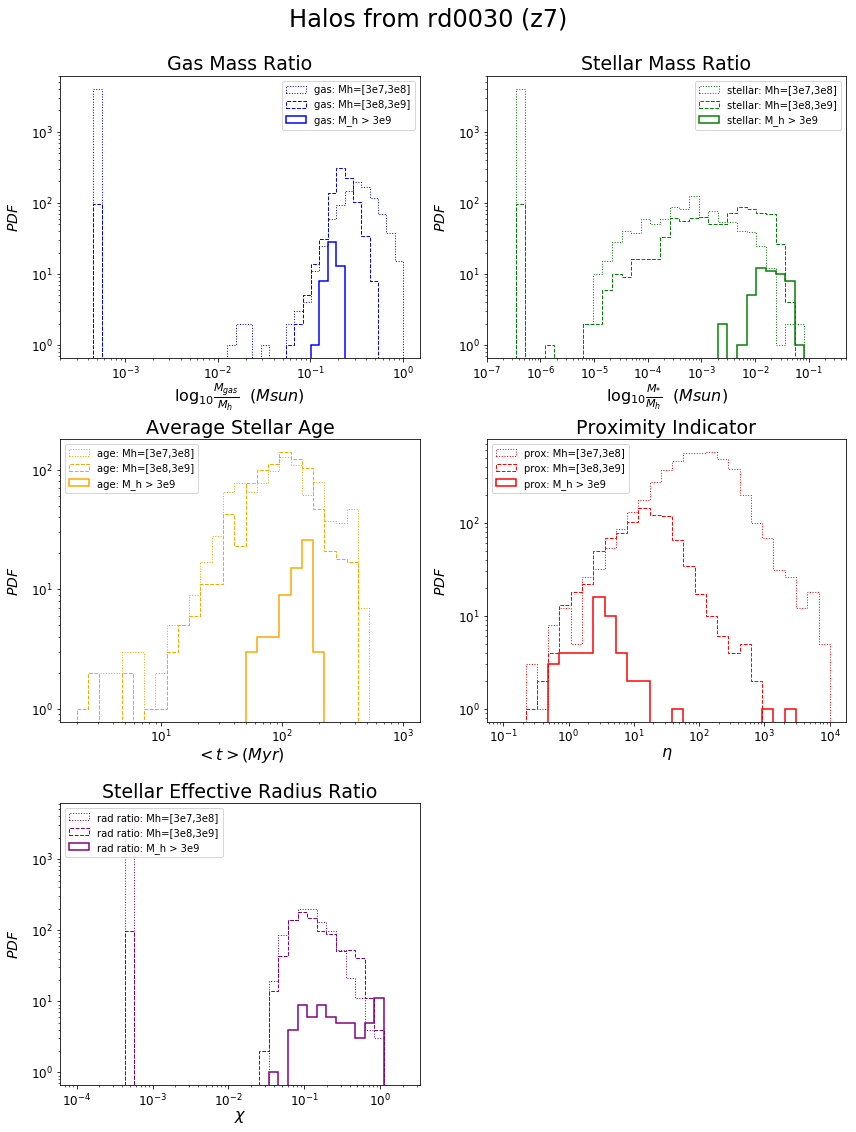

In [567]:
# create subplots
fig1 = plt.figure(figsize = (12,16))
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3)
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5)

# plot titles
figtitle = "Halos from rd0030 (z7)"
gastitle = "Gas Mass Ratio"
stellartitle = "Stellar Mass Ratio"
agetitle = "Average Stellar Age"
proxtitle = "Proximity Indicator"
radtitle = "Stellar Effective Radius Ratio"

# plot various lists
ratiolists = [ratiolist1, ratiolist2]
ax1.hist(new_ratiolist11, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax1.hist(new_ratiolist12, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax1.hist(new_ratiolist13, gasbins, ec = 'blue', lw = 1.5, label = 'gas: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax2.hist(new_ratiolist21, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax2.hist(new_ratiolist22, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax2.hist(new_ratiolist23, stelbins, ec = 'green', lw = 1.5, label = 'stellar: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax3.hist(ave_agelist1, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax3.hist(ave_agelist2, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax3.hist(ave_agelist3, agebins, ec = 'orange', lw = 1.5, label = 'age: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax4.hist(proxlist1, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax4.hist(proxlist2, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax4.hist(proxlist3, proxbins, ec = 'red', lw = 1.5, label = 'prox: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax5.hist(rad_ratiolist1, radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax5.hist(rad_ratiolist2, radbins, ec = 'purple', lw = 1, label = 'rad ratio: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax5.hist(rad_ratiolist3, radbins, ec = 'purple', lw = 1.5, label = 'rad ratio: M_h > 3e9', linestyle = "-", histtype='step', fill = False)

# set title
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(gastitle, size = 19)
ax2.set_title(stellartitle, size = 19)
ax3.set_title(agetitle, size = 19)
ax4.set_title(proxtitle, size = 19)
ax5.set_title(radtitle, size = 19)
#ax1.axis([1e-4, 10**1.5, 0, 700])

# create axis labels
gaslab = r"$\log_{10}\frac{M_{gas}}{M_h}$  $(Msun)$"
stellab = r"$\log_{10}\frac{M_{*}}{M_h}$  $(Msun)$"
agelab = r"$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
ylab = "$PDF$"
ax1.set_xlabel(gaslab, size = 16, labelpad= 0)
ax2.set_xlabel(stellab, size = 16, labelpad= 0)
ax3.set_xlabel(agelab, size = 16, labelpad= 0)
ax4.set_xlabel(proxlab, size = 16, labelpad= 0)
ax5.set_xlabel(radlab, size = 16, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax2.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax3.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax4.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax5.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.tick_params(axis='x', which='major', labelsize=12)
ax5.tick_params(axis='y', which='major', labelsize=12)


# add labels for each plot
# annotation1 = 'using .sum'
# annotation2 = 'using particle mask'
# ax1.text(start, 20, annotation1, size = 12)
# ax2.text(start, 30, annotation2, size = 12)

# set axis limits
ax2.set_xlim([1e-7, 0.5])

# add legend
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')
ax5.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig1.subplots_adjust(top=0.92)
plt.show()

#plt.savefig('./LG4_2048_40pc/rd0070/massratios.png', dpi = 300)

In [564]:
new_logratio21 = np.log([value for value in new_ratiolist21 if value > 0]) / log(10)
new_logratio22 = np.log([value for value in new_ratiolist22 if value > 0]) / log(10)
new_logratio23 = np.log([value for value in new_ratiolist23 if value > 0]) / log(10)

age_log1 = np.log([value for value in ave_agelist1 if value > 0]) / log(10)
age_log2 = np.log([value for value in ave_agelist2 if value > 0]) / log(10)
age_log3 = np.log([value for value in ave_agelist3 if value > 0]) / log(10)
plot_agelog1 = 3**(age_log1**2)/10
plot_agelog2 = 3**(age_log2**2)/10
plot_agelog3 = 3**(age_log3**2)/10

In [506]:
plot_agelog1

array([  7.33183494,   1.39568457,  48.39077363, ...,   0.1       ,
         0.1       ,   0.1       ])

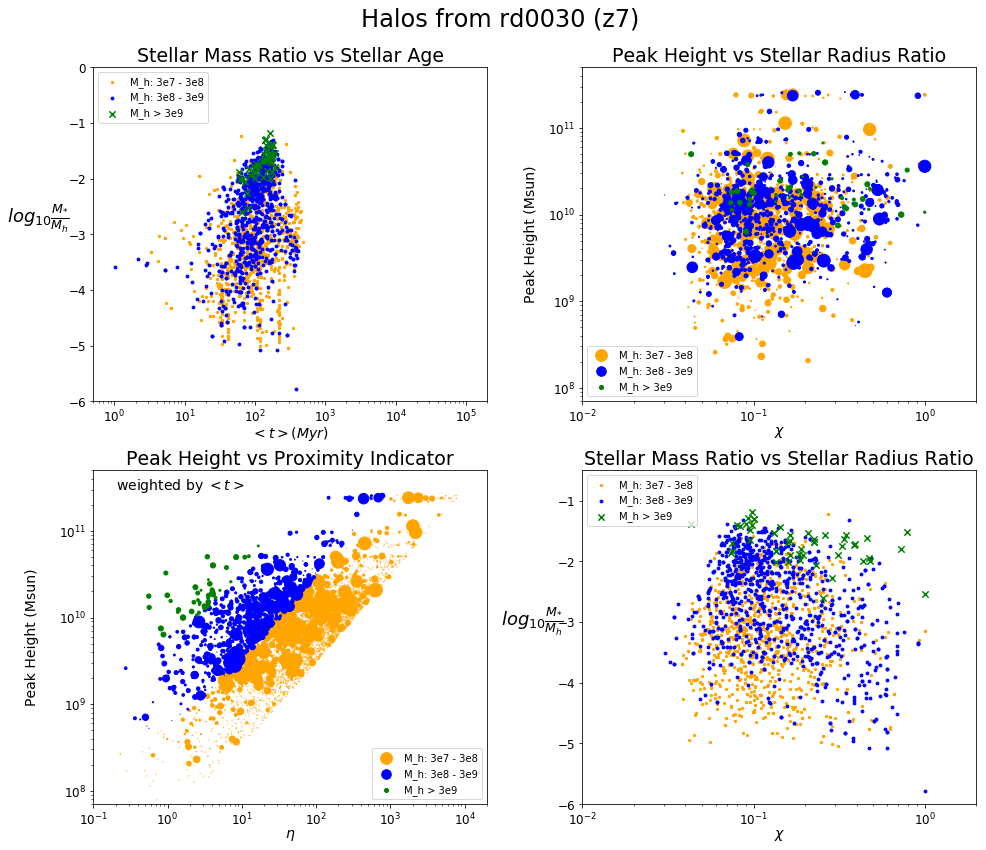

In [565]:
# specify figure size
fig2 = plt.figure(figsize=(14,12))
ax1 = fig2.add_subplot(221)
ax2 = fig2.add_subplot(222)
ax3 = fig2.add_subplot(223)
ax4 = fig2.add_subplot(224)

# create plot titles
agetitle = "Stellar Mass Ratio vs Stellar Age"
peaktitle = "Peak Height vs Stellar Radius Ratio"
proxpeaktitle = "Peak Height vs Proximity Indicator"
radratiotitle = "Stellar Mass Ratio vs Stellar Radius Ratio"

# set titles
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(agetitle, size = 19)
ax2.set_title(peaktitle, size = 19)
ax3.set_title(proxpeaktitle, size = 19)
ax4.set_title(radratiotitle, size = 19)

# # --determine line of best fit
# # reduce range of values to fit line
# bin_edges_fit1 = bin_edges1[8:-10]
# bin_edges_fit2 = bin_edges2[16:-4]
# log_density_fit1 = log_density1[7:-10]
# log_density_fit2 = log_density2[15:-4]
# # determine line
# par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
# par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
# slope1, intercept1 = par1[0][0], par1[0][1]
# slope2, intercept2 = par2[0][0], par2[0][1]

# plot data 
ax1.scatter(ave_agelist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax1.scatter(ave_agelist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax1.scatter(ave_agelist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')

ax2.scatter(rad_ratiolist1, new_peaklist1, c = 'orange', s = plot_agelog1, cmap='binary', label = 'M_h: 3e7 - 3e8')
ax2.scatter(rad_ratiolist2, new_peaklist2, c = 'blue', s = plot_agelog2, cmap='binary', label = 'M_h: 3e8 - 3e9')
ax2.scatter(rad_ratiolist3, new_peaklist3, c = 'green', s = plot_agelog3, cmap='binary', label = 'M_h > 3e9')

ax3.scatter(proxlist1, new_peaklist1, c = 'orange', s = plot_agelog1, cmap='binary', label = 'M_h: 3e7 - 3e8')
ax3.scatter(proxlist2, new_peaklist2, c = 'blue', s = plot_agelog2, cmap='binary', label = 'M_h: 3e8 - 3e9')
ax3.scatter(proxlist3, new_peaklist3, c = 'green', s = plot_agelog3, cmap='binary', label = 'M_h > 3e9')

ax4.scatter(rad_ratiolist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax4.scatter(rad_ratiolist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax4.scatter(rad_ratiolist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
# ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
# ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')

# create axis labels
agelab = "$<t> (Myr)$"
proxlab = r"$\eta$"
radlab = r"$\chi$"
peaklab = "Peak Height (Msun)"
ylab = r"$log_{10}\frac{M_{*}}{M_h}$"
ax1.set_xlabel(agelab, size = 14, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 30)
ax2.set_xlabel(radlab, size = 14, labelpad= 0)
ax2.set_ylabel(peaklab, rotation = 90, size = 14, labelpad= 10)
ax3.set_xlabel(proxlab, size = 14, labelpad= 0)
ax3.set_ylabel(peaklab, rotation = 90, size = 14, labelpad= 20)
ax4.set_xlabel(radlab, size = 14, labelpad= 0)
ax4.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 25)

# create axis ticks and set axis lim
ax1.set_xscale('log')
ax1.set_xlim([5e-1, 2e5])
ax1.set_ylim([-6, 0])
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-2, 2e0])
ax2.set_ylim([7e7, 5e11])
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1e-1,2e4])
ax3.set_ylim([7e7, 5e11])
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)

ax4.set_xscale('log')
ax4.set_xlim([1e-2, 2e0])
ax4.set_ylim([-6, -0.5])
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)

# add annotation
annotation = r"weighted by $<t>$"
ax3.text(2e-1, 3e11, annotation, size = 14)

# add legend
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower left')
ax3.legend(loc = 'lower right')
ax4.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig2.subplots_adjust(top=0.91)
plt.show()

# 7-12, 26-27, 24-32, 45-53

In [452]:
# convert lists to np arrays
ratioarray1 = np.array(new_ratiolist21)
ratioarray2 = np.array(new_ratiolist22)
ratioarray3 = np.array(new_ratiolist23)
agelog1 = np.log(ave_agelist1) / log(10)
agelog2 = np.log(ave_agelist2) / log(10)
agelog3 = np.log(ave_agelist3) / log(10)


# find stdev for lists
stdevratio1 = np.std(new_logratio21[new_logratio21 > -6])
stdevratio2 = np.std(new_logratio22[new_logratio22 > -6])
stdevratio3 = np.std(new_logratio23[new_logratio23 > -6])

stdevage1 = np.std(agelog1[0 < agelog1])
stdevage2 = np.std(agelog2[0 < agelog2])
stdevage3 = np.std(agelog3[0 < agelog3])

# find mean and medians for lists
meanratio1 = np.mean(new_logratio21[new_logratio21 > -6])
meanratio2 = np.mean(new_logratio22[new_logratio22 > -6])
meanratio3 = np.median(new_logratio23[new_logratio23 > -6])

meanage1 = np.mean(agelog1[0 < agelog1])
meanage2 = np.mean(agelog2[0 < agelog2])
meanage3 = np.median(agelog3[0 < agelog3])

In [453]:
# create corresp lists of stdev, mean, medians
masslist = [3e7, 3e8, 3e9]

ratiodevlist = [stdevratio1, stdevratio2, stdevratio3]
agedevlist = [stdevage1, stdevage2, stdevage3]

ratiomeanlist = [meanratio1, meanratio2, meanratio3]
agemeanlist = [meanage1, meanage2, meanage3]

In [454]:
print(ratiomeanlist)
print(ratiodevlist)
print(agemeanlist)
print(agedevlist)

[-3.2843315191123574, -2.7556128891453073, -1.6853447916460855]
[0.75109745779841497, 0.80332221129882297, 0.33013826980324279]
[1.9450679701195561, 1.9645075383044319, 2.1437796633831536]
[0.34897049894105231, 0.28450211613852616, 0.1417706779145414]


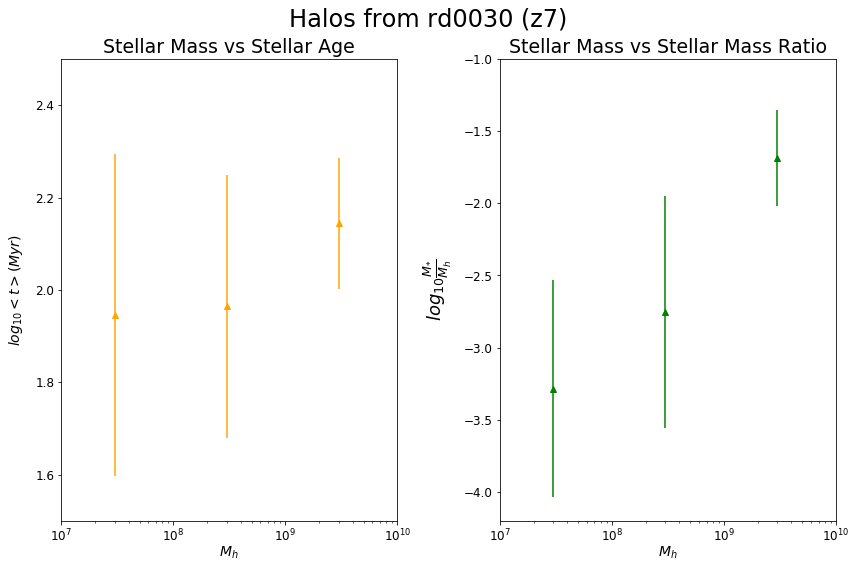

In [463]:
# specify figure size
fig3 = plt.figure(figsize=(12,8))
ax1 = fig3.add_subplot(121)
ax2 = fig3.add_subplot(122)

# create plot titles
agetitle = "Stellar Mass vs Stellar Age"
massratiotitle = "Stellar Mass vs Stellar Mass Ratio"

# set plot titles
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(agetitle, size = 19)
ax2.set_title(massratiotitle, size = 19)

# create plots
ax1.errorbar(masslist, agemeanlist, agedevlist, c = 'orange', marker="^", linestyle='None')
ax2.errorbar(masslist, ratiomeanlist, ratiodevlist, c = 'green', marker="^", linestyle='None')

# create axis labels
agelab = "$log_{10}<t> (Myr)$"
ratiolab = r"$log_{10}\frac{M_{*}}{M_h}$"
masslab = r"$M_h$"
ax1.set_xlabel(masslab, size = 14, labelpad= 0)
ax1.set_ylabel(agelab, rotation = 90, size = 14, labelpad= 10)
ax2.set_xlabel(masslab, size = 14, labelpad= 0)
ax2.set_ylabel(ratiolab, rotation = 90, size = 18, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# set axis limits
ax1.set_xlim([1e7, 1e10])
ax1.set_ylim([1.5, 2.5])
ax2.set_xlim([1e7, 1e10])
ax2.set_ylim([-4.2, -1])

# adjust spacing and show
plt.tight_layout()
fig3.subplots_adjust(top=0.89)
plt.show()

In [124]:
# find log arrays for ratio lists
log_ratio1 = np.log(ratiolist1) / log(10)
log_ratio2 = np.log([value for value in ratiolist2 if value > 0]) / log(10)

# find histogram parameters
density1, bin_edges1 = np.histogram(log_ratio1, bins= np.linspace(-3.5, 0.4, 39))
density2, bin_edges2 = np.histogram(log_ratio2, bins= np.linspace(-2.2, 1.1, 33))


log_density1 = np.log(density1) / log(10)
log_density2 = np.log(density2) / log(10)

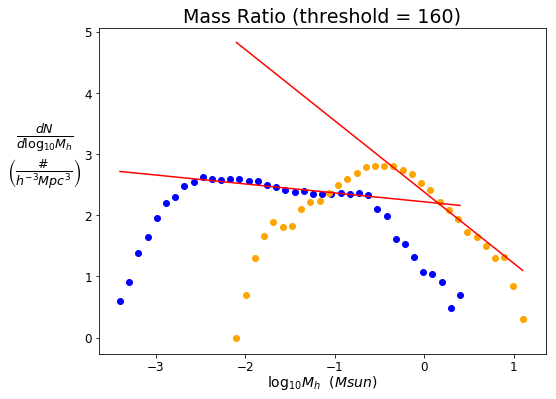

In [161]:
# specify figure size
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

# --determine line of best fit
# reduce range of values to fit line
bin_edges_fit1 = bin_edges1[8:-10]
bin_edges_fit2 = bin_edges2[16:-4]
log_density_fit1 = log_density1[7:-10]
log_density_fit2 = log_density2[15:-4]
# determine line
par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
slope1, intercept1 = par1[0][0], par1[0][1]
slope2, intercept2 = par2[0][0], par2[0][1]

# plot data and line
bin_edges_red1 = bin_edges1[1:]
bin_edges_red2 = bin_edges2[1:]
ax2.scatter(bin_edges_red1, log_density1, color = 'blue')
ax2.scatter(bin_edges_red2, log_density2, color = 'orange')
ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')
ax2.set_title("Mass Ratio (threshold = 160)", size = 19)

# create axis labels
xlab = "$\log_{10}M_h}$  $(Msun)$"
ylab = r"$\frac{dN}{d\log_{10}M_h}$"+"\n"+r"$\left(\frac{\#}{h^{-3}Mpc^3}\right)$"
ax2.set_xlabel(xlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)

# create axis ticks 
ax2.set_yscale('linear')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# add slope and intercept
# annotation = "$a = {:1.3f}$ \n$b = {:1.3f}$".format(slope, intercept)
# plt.text(9.5, 1.5, annotation, size = 12)

#show and save
plt.show()